
Running analysis with p-norm = 0.5
Running analysis on GPU 1 with 2000 points in 20000 dimensions
Using L0.5 norm (p=0.5)
Using device: cuda:1
Generated points in 0.01 seconds
Processing x1 = 0.0
Processing x1 = 0.2
Processing x1 = 0.4
Processing x1 = 0.6
Processing x1 = 0.8
Processing x1 = 1.0
Processing x1 = 1.2
Processing x1 = 1.4
Processing x1 = 1.6
Processing x1 = 1.8
Processing x1 = 2.0
Processing x1 = 2.2
Processing x1 = 2.4
Processing x1 = 2.6
Processing x1 = 2.8
Processing x1 = 3.0
Processing x1 = 3.2
Processing x1 = 3.4
Processing x1 = 3.6
Processing x1 = 3.8
Processing x1 = 4.0
Processing x1 = 4.2
Processing x1 = 4.4
Processing x1 = 4.6
Processing x1 = 4.8
Processing x1 = 5.0
Processing x1 = 5.2
Processing x1 = 5.4
Processing x1 = 5.6
Processing x1 = 5.8
k=1: correlation=-0.5872, p-value=0.0006
k=2: correlation=-0.5960, p-value=0.0005
k=3: correlation=-0.6047, p-value=0.0004
k=4: correlation=-0.6096, p-value=0.0003
k=6: correlation=-0.6156, p-value=0.0003
k=8: correlation=-

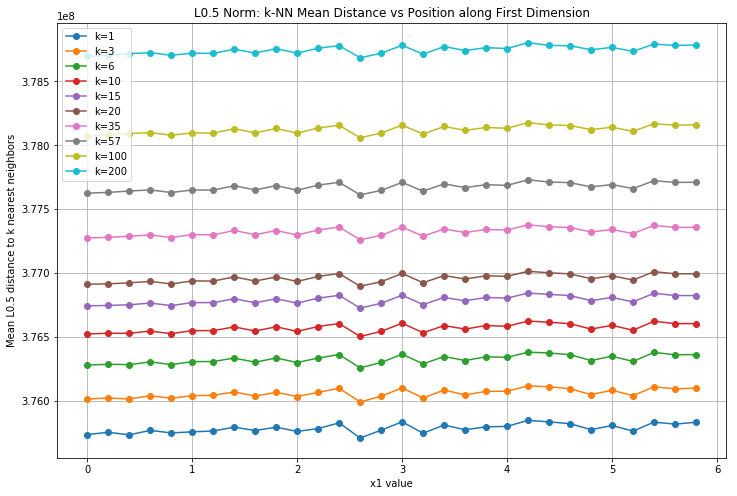

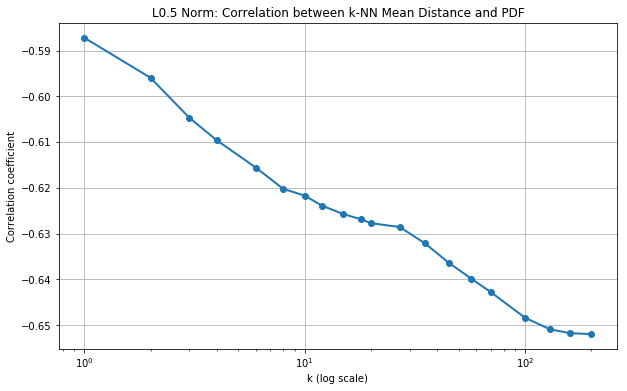

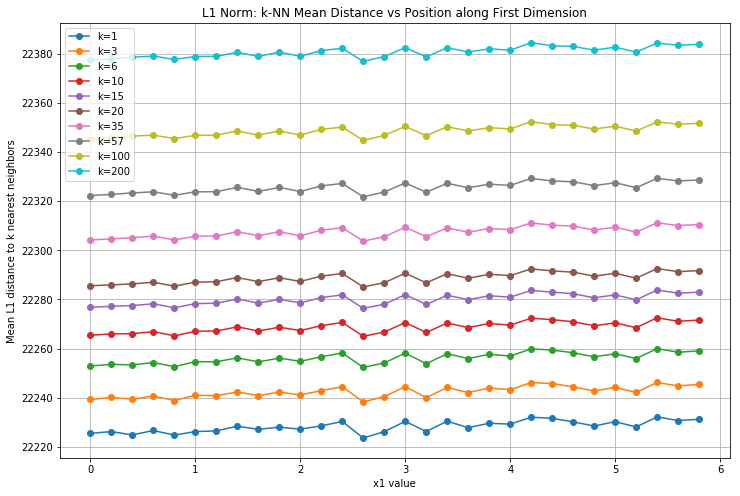

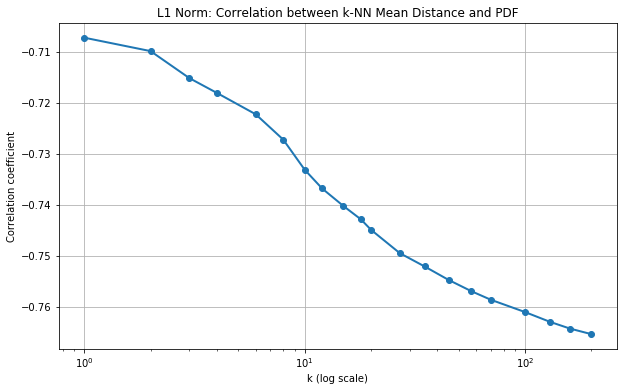

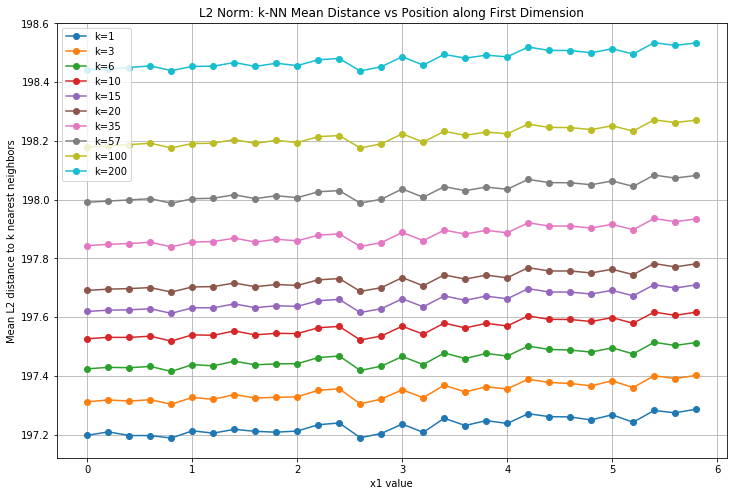

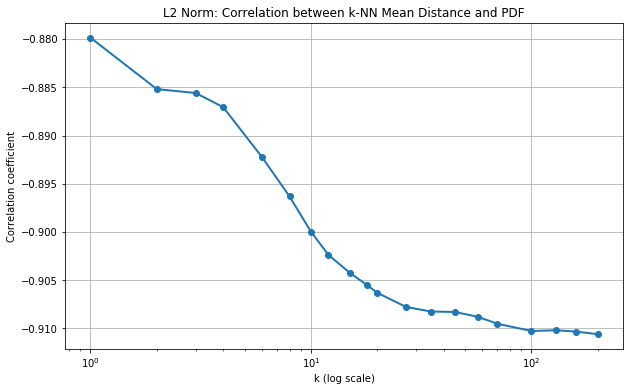

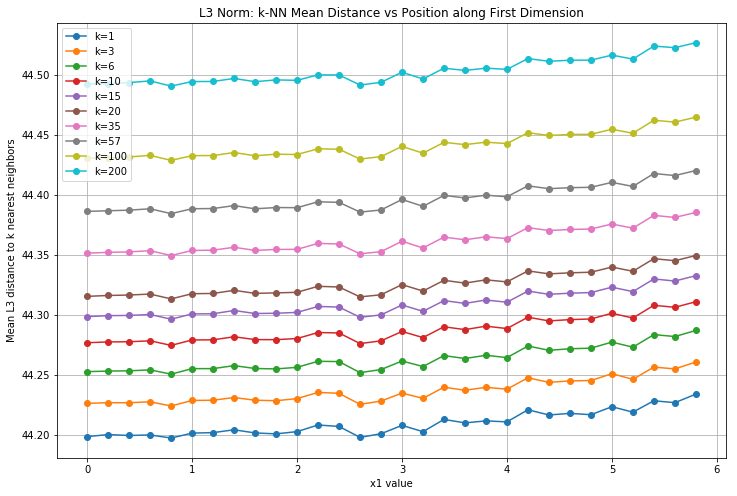

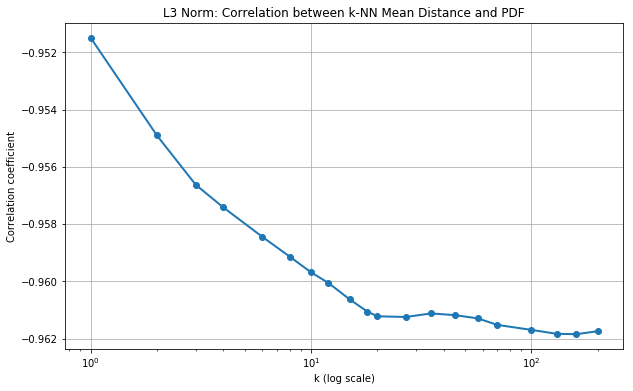

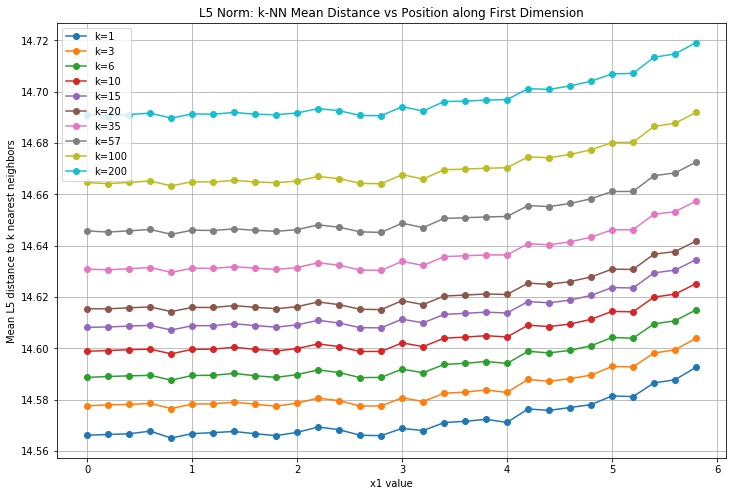

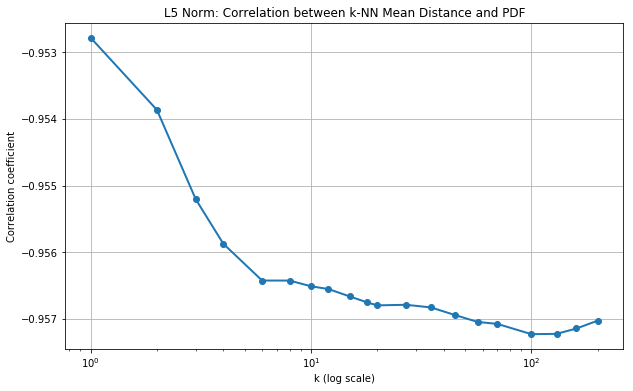

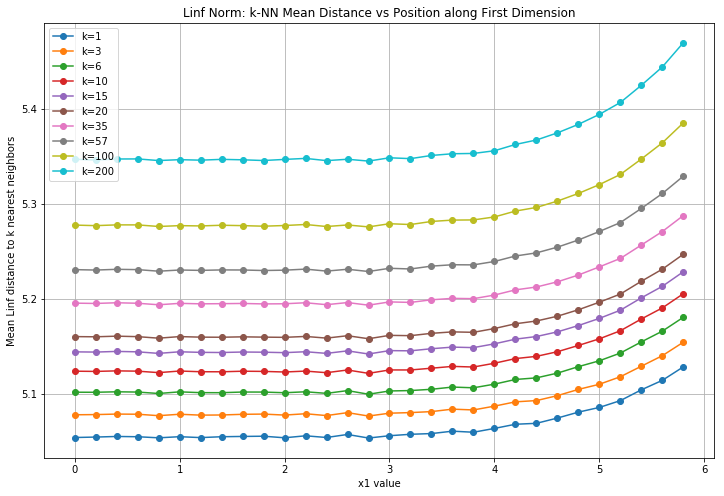

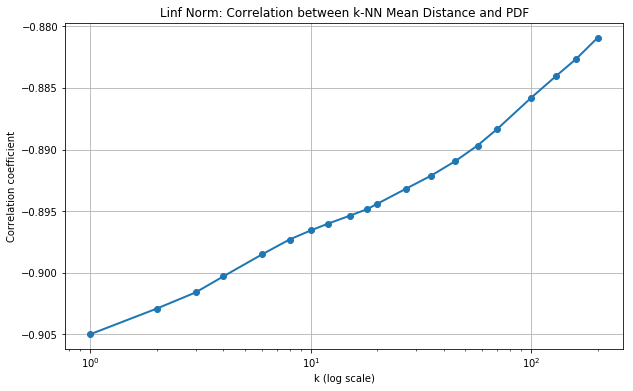

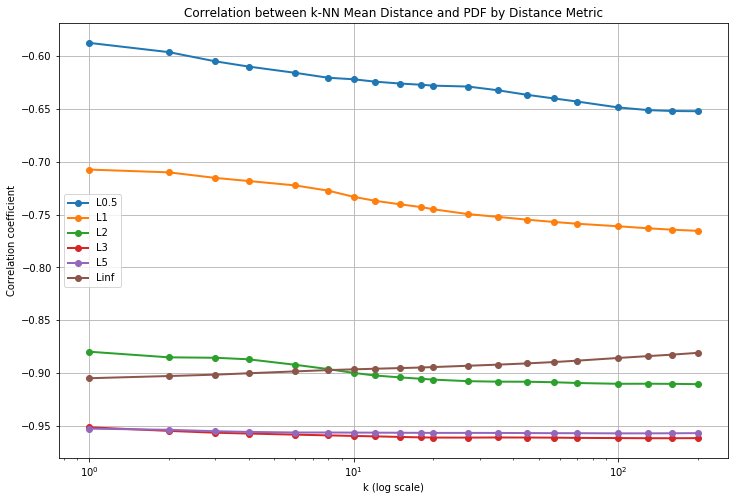

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time

def knn_analysis(n_points=2000, n_dim=20000, p_norm='2', gpu_id=0, seed=42):
    """
    Analyze k-NN behavior in high dimensions and correlate with PDF using specified p-norm.
    
    Args:
        n_points: Number of points to sample
        n_dim: Dimensionality of the space
        p_norm: Power of the norm to use (1=Manhattan, 2=Euclidean, 'inf'=Chebyshev)
               Can also be values below 1 like 0.5
        gpu_id: GPU to use (0-3)
        seed: Random seed for reproducibility
    """
    # Convert p_norm to appropriate type
    if p_norm == 'inf':
        p = float('inf')
    else:
        p = float(p_norm)
    
    print(f"Running analysis on GPU {gpu_id} with {n_points} points in {n_dim} dimensions")
    print(f"Using L{p_norm} norm (p={p})")
    
    # Set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Set the device
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    if not torch.cuda.is_available():
        print("Warning: CUDA not available, falling back to CPU")
    else:
        print(f"Using device: {device}")
    
    # Generate random points - N(0,I)
    start_time = time.time()
    X = torch.randn(n_points, n_dim, device=device)
    print(f"Generated points in {time.time() - start_time:.2f} seconds")
    
    # Values of k to analyze
    k_values = [1, 2, 3, 4, 6, 8, 10, 12, 15, 18, 20, 27, 35, 45, 57, 70, 100, 130, 160, 200]
    
    # Sample points along first dimension for PDF evaluation
    x1_values = np.arange(0, 6, 0.2)
    n_samples = len(x1_values)
    
    # Store results for each k
    correlations = []
    mean_distances = np.zeros((len(k_values), n_samples))
    
    # Compute log PDF values (without the exponential)
    # n*log(8/sqrt(pi)) + sum xi^2
    log_const = n_dim * np.log(8/np.sqrt(np.pi))
    
    # For each point in x1_values, sample points and compute k-NN distances
    for i, x1 in enumerate(x1_values):
        print(f"Processing x1 = {x1:.1f}")
        
        # Create test points with first dimension fixed to x1
        X_test = torch.randn(n_points, n_dim, device=device)
        X_test[:, 0] = x1  # Set first dimension to x1
        
        # Compute distances based on the norm type
        batch_size = 100
        all_distances = []
        
        for b in range(0, n_points, batch_size):
            end_idx = min(b + batch_size, n_points)
            batch = X_test[b:end_idx]
            
            if p == 2:
                # Special case for Euclidean distance (L2 norm)
                # Use the efficient method
                batch_norm = torch.sum(batch**2, dim=1, keepdim=True)
                X_norm = torch.sum(X**2, dim=1, keepdim=True).T
                dot_product = 2 * torch.mm(batch, X.T)
                dist_sq = batch_norm + X_norm - dot_product
                dist_sq = torch.clamp(dist_sq, min=0.0)  # Handle numerical errors
                distances = torch.sqrt(dist_sq)
            elif p == float('inf'):
                # Special case for maximum norm (L∞)
                distances = torch.zeros(end_idx - b, n_points, device=device)
                # Process in dimension chunks to save memory
                chunk_size = 1000
                for dim_start in range(0, n_dim, chunk_size):
                    dim_end = min(dim_start + chunk_size, n_dim)
                    # Get current chunk
                    batch_chunk = batch[:, dim_start:dim_end]
                    X_chunk = X[:, dim_start:dim_end]
                    # Compute absolute differences for this chunk
                    diff_chunk = torch.abs(batch_chunk.unsqueeze(1) - X_chunk.unsqueeze(0))
                    # Update max distances
                    chunk_max = torch.max(diff_chunk, dim=2)[0]
                    distances = torch.max(distances, chunk_max)
            else:
                # General case for any Lp norm
                distances = torch.zeros(end_idx - b, n_points, device=device)
                # Process in dimension chunks to save memory
                chunk_size = 1000
                for dim_start in range(0, n_dim, chunk_size):
                    dim_end = min(dim_start + chunk_size, n_dim)
                    # Get current chunk
                    batch_chunk = batch[:, dim_start:dim_end]
                    X_chunk = X[:, dim_start:dim_end]
                    # Compute powered differences for this chunk
                    diff_chunk = torch.abs(batch_chunk.unsqueeze(1) - X_chunk.unsqueeze(0))
                    powered_diff = torch.pow(diff_chunk, p)
                    # Add to accumulated distances
                    distances += torch.sum(powered_diff, dim=2)
                
                # Apply final power
                distances = torch.pow(distances, 1/p)
            
            all_distances.append(distances)
        
        # Concatenate all batches
        distances_matrix = torch.cat(all_distances, dim=0)
        
        # For each k, compute the mean of the k nearest neighbors
        for j, k in enumerate(k_values):
            # Sort distances and get the k nearest neighbors for each point
            k_nearest, _ = torch.topk(distances_matrix, k+1, dim=1, largest=False)
            
            # Remove the first distance (which might be self-distance)
            k_nearest = k_nearest[:, 1:k+1]
            
            # Compute mean distance to k nearest neighbors
            mean_dist = torch.mean(k_nearest, dim=1).cpu().numpy()
            mean_distances[j, i] = np.mean(mean_dist)
    
    # For each k, compute correlation between mean distance and log PDF
    for j, k in enumerate(k_values):
        # We need to exponentiate log_pdf_term for correlation
        # But to avoid numerical issues, we'll compute correlation with the log values
        # This is valid since correlation is invariant to monotonic transformations
        pdf_values = -0.5 * np.array([log_const + x1**2 for x1 in x1_values])
        corr, p_value = pearsonr(pdf_values, mean_distances[j, :])
        correlations.append((k, corr, p_value))
        print(f"k={k}: correlation={corr:.4f}, p-value={p_value:.4f}")
    
    # Plot results
    plt.figure(figsize=(12, 8))
    
    # If there are many k values, only plot some for clarity
    if len(k_values) > 10:
        plot_indices = np.linspace(0, len(k_values)-1, 10, dtype=int)
        plot_k_values = [k_values[i] for i in plot_indices]
    else:
        plot_indices = range(len(k_values))
        plot_k_values = k_values
    
    for idx in plot_indices:
        plt.plot(x1_values, mean_distances[idx, :], marker='o', label=f'k={k_values[idx]}')
    
    plt.xlabel('x1 value')
    plt.ylabel(f'Mean L{p_norm} distance to k nearest neighbors')
    plt.title(f'L{p_norm} Norm: k-NN Mean Distance vs Position along First Dimension')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'knn_distances_p{p_norm}.png')
    
    # Correlation plot
    plt.figure(figsize=(10, 6))
    k_array = np.array(k_values)
    corr_array = np.array([c[1] for c in correlations])
    
    plt.semilogx(k_array, corr_array, marker='o', linewidth=2)
    plt.xlabel('k (log scale)')
    plt.ylabel('Correlation coefficient')
    plt.title(f'L{p_norm} Norm: Correlation between k-NN Mean Distance and PDF')
    plt.grid(True)
    plt.savefig(f'knn_correlation_p{p_norm}.png')
    
    # Return results
    return {
        'p_norm': p_norm,
        'k_values': k_values,
        'correlations': correlations,
        'mean_distances': mean_distances,
        'x1_values': x1_values
    }





norms_to_test = ['0.5', '1', '2', '3', '5', 'inf']
all_results = {}
for norm in norms_to_test:
    print(f"\nRunning analysis with p-norm = {norm}")
    all_results[norm] = knn_analysis(n_points=2000, n_dim=20000, p_norm=norm, gpu_id=1)
# #
#combined correlation plot for all norms
plt.figure(figsize=(12, 8))
for norm, results in all_results.items():
    k_values = results['k_values']
    correlations = [c[1] for c in results['correlations']]
    plt.semilogx(k_values, correlations, marker='o', linewidth=2, label=f'L{norm}')
plt.xlabel('k (log scale)')

plt.ylabel('Correlation coefficient')
plt.title('Correlation between k-NN Mean Distance and PDF by Distance Metric')
plt.legend()
plt.grid(True)
plt.savefig('knn_correlations_all_norms.png')

In [1]:
from numba import cuda
cuda.select_device(1)
cuda.close()
print("dkf,")

dkf,


In [4]:
import torch, pandas as pd, numpy as np, time
from tqdm import tqdm
from scipy import stats

def compute_10nn_distributions_and_fit_gaussians(data_path, batch_size=2000, chunk_size=5000):
    """
    Compute 10-NN distance distributions for class 0 and whole dataset,
    then fit Gaussian distributions and return parameters.
    """
    start_time = time.time()
    
    # Explicitly select GPU 1
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load and prepare data
    df = pd.read_parquet(data_path)
    classes = df.iloc[:, 0].values
    class0_indices = np.where(classes == 0)[0]
    
    print(f"Total: {len(df)}, Class 0: {len(class0_indices)}")
    
    class0_features = torch.tensor(df.iloc[class0_indices, 1:].values, dtype=torch.float32, device=device)
    features_tensor = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32, device=device)
    
    # Initialize lists to store 10-NN distances
    knn_distances_whole = []
    knn_distances_class0 = []
    
    # 1. Compute 10-NN distances for whole dataset
    k = 10
    print("Computing 10-NN distances for whole dataset...")
    for start_idx in tqdm(range(0, len(features_tensor), batch_size)):
        end_idx = min(start_idx + batch_size, len(features_tensor))
        batch = features_tensor[start_idx:end_idx]
        
        # Calculate distances from batch to all points
        distances = torch.cdist(batch, features_tensor, p=1)
        
        # For each point in the batch, exclude self-distance and find k nearest
        for i, global_idx in enumerate(range(start_idx, end_idx)):
            # Set distance to self to infinity
            distances[i, global_idx] = float('inf')
            
            # Get k smallest distances
            topk_values, _ = torch.topk(distances[i], k=k, largest=False)
            
            # Get the k-th nearest neighbor distance
            kth_distance = topk_values[k-1].item()
            knn_distances_whole.append(kth_distance)
    
    # 2. Compute 10-NN distances for class 0 only
    print("Computing 10-NN distances for class 0...")
    for start_idx in tqdm(range(0, len(class0_features), batch_size)):
        end_idx = min(start_idx + batch_size, len(class0_features))
        batch = class0_features[start_idx:end_idx]
        
        # Calculate distances from batch to class 0 points
        distances = torch.cdist(batch, class0_features, p=1)
        
        # For each point in the batch, exclude self-distance and find k nearest
        for i, global_idx in enumerate(range(start_idx, end_idx)):
            # Set distance to self to infinity
            distances[i, global_idx] = float('inf')
            
            # Get k smallest distances
            topk_values, _ = torch.topk(distances[i], k=k, largest=False)
            
            # Get the k-th nearest neighbor distance
            kth_distance = topk_values[k-1].item()
            knn_distances_class0.append(kth_distance)
    
    # 3. Fit Gaussian distributions to the distance data
    # For whole dataset
    whole_mean, whole_std = stats.norm.fit(knn_distances_whole)
    whole_variance = whole_std ** 2
    
    # For class 0
    class0_mean, class0_std = stats.norm.fit(knn_distances_class0)
    class0_variance = class0_std ** 2
    
    print(f"Runtime: {time.time() - start_time:.2f} seconds")
    
    return whole_mean, whole_variance, class0_mean, class0_variance

# Execute analysis
if __name__ == "__main__":
    whole_mean, whole_variance, class0_mean, class0_variance = compute_10nn_distributions_and_fit_gaussians(
        data_path='data_norm.parquet',
        batch_size=1000,
        chunk_size=5000
    )
    
    # Print just the four gaussian parameters
    print(f"Whole Dataset Gaussian: Mean = {whole_mean:.6f}, Variance = {whole_variance:.6f}")
    print(f"Class 0 Gaussian: Mean = {class0_mean:.6f}, Variance = {class0_variance:.6f}")

Using device: cuda:1
Total: 9349, Class 0: 669


  0%|          | 0/10 [00:00<?, ?it/s]

Computing 10-NN distances for whole dataset...


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]

Computing 10-NN distances for class 0...
Runtime: 22.13 seconds
Whole Dataset Gaussian: Mean = 8304.722022, Variance = 4707926.898804
Class 0 Gaussian: Mean = 5950.676427, Variance = 3400381.504375


In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from itertools import combinations
import time
from datetime import datetime
import gc

class MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2000)
        self.bn1 = nn.BatchNorm1d(2000)
        self.dropout1 = nn.Dropout(0.02)
        self.fc2 = nn.Linear(2000, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.dropout2 = nn.Dropout(0.02)
        self.fc3 = nn.Linear(200, 20)
        self.bn3 = nn.BatchNorm1d(20)
        self.dropout3 = nn.Dropout(0.02)
        self.fc4 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()
        self.leaky_relu = nn.LeakyReLU(0.01)
        
    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.sigmoid(self.fc4(x))
        return x

def load_model(model_path, input_size, device):
    """Load the pretrained MLP model"""
    model = MLP(input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

class OptimizedProgressTracker:
    """Optimized progress tracker with minute-based updates and chunk-level progress"""
    def __init__(self, total_samples, total_combinations, chunk_size):
        self.total_samples = total_samples
        self.total_combinations = total_combinations
        self.chunk_size = chunk_size
        self.chunks_per_sample = (total_combinations + chunk_size - 1) // chunk_size  # Ceiling division
        self.total_chunks = total_samples * self.chunks_per_sample
        self.completed_chunks = 0
        self.current_sample = 0
        self.start_time = time.time()
        self.last_update_time = self.start_time
        self.update_interval = 60.0  # 1 minute in seconds
        
        print(f"Starting optimized computation:")
        print(f"- Total samples: {total_samples:,}")
        print(f"- Total combinations: {total_combinations:,}")
        print(f"- Chunk size: {chunk_size:,}")
        print(f"- Chunks per sample: {self.chunks_per_sample:,}")
        print(f"- Total chunks: {self.total_chunks:,}")
        print("-" * 80)
    
    def update_chunk(self):
        """Update progress after completing a chunk"""
        self.completed_chunks += 1
        current_time = time.time()
        
        # Update every minute OR every 10 chunks (whichever comes first)
        time_for_update = current_time - self.last_update_time >= self.update_interval
        chunk_milestone = self.completed_chunks % 10 == 0
        
        if time_for_update or chunk_milestone:
            progress_pct = (self.completed_chunks / self.total_chunks) * 100
            current_sample_progress = (self.completed_chunks % self.chunks_per_sample) / self.chunks_per_sample * 100
            elapsed_time = current_time - self.start_time
            
            if self.completed_chunks > 0:
                estimated_total_time = elapsed_time * (self.total_chunks / self.completed_chunks)
                remaining_time = estimated_total_time - elapsed_time
                eta = current_time + remaining_time
                eta_formatted = datetime.fromtimestamp(eta).strftime("%H:%M:%S")
                
                # Calculate chunks per second
                chunks_per_second = self.completed_chunks / elapsed_time
            else:
                eta_formatted = "Unknown"
                chunks_per_second = 0
            
            print(f"[{datetime.now().strftime('%H:%M:%S')}] Progress: {progress_pct:.3f}% "
                  f"(Sample {self.current_sample+1}/{self.total_samples}: {current_sample_progress:.1f}%) "
                  f"- {self.completed_chunks:,}/{self.total_chunks:,} chunks "
                  f"- {chunks_per_second:.1f} chunks/sec - ETA: {eta_formatted}")
            
            self.last_update_time = current_time
    
    def start_sample(self, sample_idx):
        """Called when starting a new sample"""
        self.current_sample = sample_idx
        current_time = time.time()
        if sample_idx > 0:  # Don't print for first sample
            elapsed = current_time - self.start_time
            print(f"[{datetime.now().strftime('%H:%M:%S')}] Starting sample {sample_idx+1}/{self.total_samples} "
                  f"- Elapsed: {elapsed/60:.1f} min")
    
    def finish(self):
        """Print final completion message"""
        total_time = time.time() - self.start_time
        current_time = datetime.now()
        chunks_per_second = self.total_chunks / total_time if total_time > 0 else 0
        
        print("-" * 80)
        print(f"[{current_time.strftime('%H:%M:%S')}] Computation completed!")
        print(f"Total time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
        print(f"Chunks per second: {chunks_per_second:.1f}")
        print(f"Samples per hour: {self.total_samples/(total_time/3600):.1f}")
        print(f"Total chunks processed: {self.total_chunks:,}")

def vectorized_10nn_distances(candidates, reference_data, device):
    """
    Highly optimized vectorized 10-NN computation for GPU
    candidates: (n_candidates, n_features) 
    reference_data: (n_reference, n_features)
    """
    # Use optimized broadcasting for L1 distances
    # candidates: (n_candidates, 1, n_features)
    # reference_data: (1, n_reference, n_features)
    candidates_expanded = candidates.unsqueeze(1)
    reference_expanded = reference_data.unsqueeze(0)
    
    # Compute all pairwise L1 distances at once
    distances = torch.sum(torch.abs(candidates_expanded - reference_expanded), dim=2)
    
    # Get k-NN distances efficiently
    k = min(10, reference_data.shape[0])
    knn_distances = torch.topk(distances, k, dim=1, largest=False)[0]
    
    return knn_distances.mean(dim=1)

def generate_candidates_chunk_vectorized(class1_batch, feature_combinations_chunk, feature_ranges, device):
    """
    Generate candidates for a chunk of feature combinations using vectorized operations
    Memory-efficient version that processes combinations in manageable chunks
    """
    batch_size, n_features = class1_batch.shape
    n_combos = len(feature_combinations_chunk)
    candidates_per_combo = 9  # 3^2 for 2 features
    
    # Pre-allocate output tensor for this chunk
    chunk_candidates = torch.zeros(batch_size, n_combos, candidates_per_combo, n_features, 
                                  device=device, dtype=torch.float32)
    
    # Create base candidates (copy original features)
    for combo_idx, (feat1_idx, feat2_idx) in enumerate(feature_combinations_chunk):
        # Get sample values for both features
        values1 = feature_ranges['sample_points'][feat1_idx]  # (3,)
        values2 = feature_ranges['sample_points'][feat2_idx]  # (3,)
        
        # Create meshgrid
        grid1, grid2 = torch.meshgrid(values1, values2, indexing='ij')
        grid1_flat = grid1.flatten()  # (9,)
        grid2_flat = grid2.flatten()  # (9,)
        
        # Copy original features for all samples and candidates
        chunk_candidates[:, combo_idx, :, :] = class1_batch.unsqueeze(1).unsqueeze(1).expand(-1, 1, candidates_per_combo, -1)
        
        # Assign new values to the varying features
        chunk_candidates[:, combo_idx, :, feat1_idx] = grid1_flat
        chunk_candidates[:, combo_idx, :, feat2_idx] = grid2_flat
    
    return chunk_candidates

def compute_scores_chunk_vectorized(candidates_chunk, class1_batch, class0_features, model, 
                                   weight_10nn, weight_l1, CLASS0_10NN_MEAN, CLASS0_10NN_STD, 
                                   L1_NORM_MEAN, L1_NORM_STD, classification_threshold, device):
    """
    Compute scores for a chunk of candidates using vectorized operations
    Memory-efficient version
    """
    batch_size, n_combos_chunk, candidates_per_combo, n_features = candidates_chunk.shape
    
    # Reshape for batch processing
    flat_candidates = candidates_chunk.view(-1, n_features)
    
    # Get all predictions at once
    with torch.no_grad():
        all_predictions = model(flat_candidates).squeeze()
        if all_predictions.dim() == 0:
            all_predictions = all_predictions.unsqueeze(0)
    
    # Reshape predictions back
    predictions_chunk = all_predictions.view(batch_size, n_combos_chunk, candidates_per_combo)
    
    # Apply classification threshold mask
    valid_mask = predictions_chunk <= classification_threshold
    
    # Compute 10-NN distances for all valid candidates
    valid_candidates_flat = flat_candidates[valid_mask.view(-1)]
    
    if valid_candidates_flat.shape[0] > 0:
        nn_distances_valid = vectorized_10nn_distances(valid_candidates_flat, class0_features, device)
    else:
        nn_distances_valid = torch.tensor([], device=device)
    
    # Compute L1 distances efficiently
    class1_expanded = class1_batch.unsqueeze(1).unsqueeze(2).expand(-1, n_combos_chunk, candidates_per_combo, -1)
    l1_distances = torch.sum(torch.abs(candidates_chunk - class1_expanded), dim=3)
    
    # Initialize score tensor
    scores_chunk = torch.full((batch_size, n_combos_chunk, candidates_per_combo), float('inf'), device=device)
    
    # Compute scores only for valid candidates
    if valid_candidates_flat.shape[0] > 0:
        # Map back the NN distances to original positions
        nn_distances_full = torch.full_like(scores_chunk.view(-1), float('inf'))
        nn_distances_full[valid_mask.view(-1)] = nn_distances_valid
        nn_distances_reshaped = nn_distances_full.view(batch_size, n_combos_chunk, candidates_per_combo)
        
        # Compute normalized penalties
        nn_penalty = torch.abs(nn_distances_reshaped - CLASS0_10NN_MEAN) / CLASS0_10NN_STD * weight_10nn
        l1_penalty = torch.abs(l1_distances - L1_NORM_MEAN) / L1_NORM_STD * weight_l1
        
        # Total scores (only where valid)
        scores_chunk[valid_mask] = nn_penalty[valid_mask] + l1_penalty[valid_mask]
    
    return scores_chunk, predictions_chunk, valid_mask

def brute_force_counterfactual_scoring(
    tcga_class0_path,
    data_eval_norm1_path,
    model_path,
    n_features_vary=2,
    n_points_per_feature=3,
    percentage_range=10,
    weight_classification=10.0,
    weight_10nn=10.0,
    weight_l1=10.0,
    gpu_id=0,
    classification_threshold=0.4,
    batch_size_candidates=2048,
    batch_size_rows=1024,
    batch_size_feature_combos=32
):
    """
    Highly optimized brute force counterfactual scoring for RTX 2080 Ti
    Optimized specifically for n_features_vary=2, n_points_per_feature=3
    """
    
    # Constants for normalization
    CLASS0_10NN_MEAN = 5950.676427
    CLASS0_10NN_STD = np.sqrt(3400381.504375)
    L1_NORM_MEAN = 6471.3016
    L1_NORM_STD = 1596.4753
    
    # Setup device with optimizations
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        torch.cuda.set_device(gpu_id)
        torch.backends.cudnn.benchmark = True  # Optimize for consistent input sizes
        torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 for faster computation
    
    print(f"Using device: {device}")
    
    start_time = time.time()
    
    # Load data
    print("Loading data...")
    class0_df = pd.read_parquet(tcga_class0_path)
    class1_df = pd.read_parquet(data_eval_norm1_path)
    
    # Extract features and move to GPU immediately
    class0_features = torch.tensor(class0_df.iloc[:, 1:].values, dtype=torch.float32, device=device)
    class1_features = torch.tensor(class1_df.iloc[:, 1:].values, dtype=torch.float32, device=device)
    
    n_class1_samples, n_features = class1_features.shape
    print(f"Data loaded: {n_class1_samples} class1 samples, {n_features} features")
    
    # Load model
    model = load_model(model_path, n_features, device)
    
    # Precompute feature ranges on GPU
    print("Precomputing feature ranges...")
    min_vals = torch.min(class0_features, dim=0)[0]
    max_vals = torch.max(class0_features, dim=0)[0]
    ranges = max_vals - min_vals
    range_adjustment = ranges * (abs(percentage_range) / 100.0)
    
    if percentage_range < 0:
        adjusted_min = min_vals - range_adjustment
        adjusted_max = max_vals + range_adjustment
    else:
        adjusted_min = min_vals - range_adjustment
        adjusted_max = max_vals + range_adjustment
    
    # Generate sample points for all features at once
    sample_points = torch.zeros(n_features, n_points_per_feature, device=device)
    for feat_idx in range(n_features):
        sample_points[feat_idx] = torch.linspace(adjusted_min[feat_idx], adjusted_max[feat_idx], n_points_per_feature)
    
    feature_ranges = {'sample_points': sample_points}
    
    # Generate feature combinations
    feature_combinations = list(combinations(range(n_features), 2))
    n_combos = len(feature_combinations)
    
    # Calculate optimal batch sizes for memory efficiency
    candidates_per_combo = n_points_per_feature ** 2
    
    # Calculate memory requirements more accurately
    # Memory per combo chunk: batch_size × chunk_size × candidates_per_combo × n_features × 4 bytes
    bytes_per_element = 4  # float32
    available_memory = 8 * 1024**3  # 8GB conservative estimate
    
    # Reserve memory for model, gradients, and other tensors (about 30% of total)
    usable_memory = int(available_memory * 0.7)
    
    # Calculate maximum combinations we can process at once
    memory_per_combo = batch_size_rows * candidates_per_combo * n_features * bytes_per_element
    max_combos_per_chunk = max(1, usable_memory // memory_per_combo)
    
    # Use smaller of calculated max or user-specified batch size
    optimal_combo_chunk_size = min(max_combos_per_chunk, batch_size_feature_combos)
    optimal_batch_size = min(batch_size_rows, usable_memory // (optimal_combo_chunk_size * candidates_per_combo * n_features * bytes_per_element))
    optimal_batch_size = max(1, optimal_batch_size)
    
    print(f"Memory optimization:")
    print(f"- Max combinations per chunk: {optimal_combo_chunk_size:,}")
    print(f"- Optimal batch size: {optimal_batch_size}")
    print(f"- Memory per chunk: {memory_per_combo * optimal_combo_chunk_size / (1024**3):.2f} GB")
    
    # Initialize progress tracker with chunk-level tracking
    progress_tracker = OptimizedProgressTracker(n_class1_samples, n_combos, optimal_combo_chunk_size)
    
    # Initialize results
    results = []
    
    # Process in memory-efficient batches
    for batch_start in range(0, n_class1_samples, optimal_batch_size):
        batch_end = min(batch_start + optimal_batch_size, n_class1_samples)
        current_batch_size = batch_end - batch_start
        
        # Notify progress tracker of new sample batch
        progress_tracker.start_sample(batch_start)
        
        # Get current batch
        class1_batch = class1_features[batch_start:batch_end]
        
        # Initialize batch results
        batch_best_scores = torch.full((current_batch_size,), float('inf'), device=device)
        batch_best_predictions = torch.zeros(current_batch_size, device=device)
        batch_best_candidates = class1_batch.clone()
        
        # Process feature combinations in chunks
        for combo_start in range(0, n_combos, optimal_combo_chunk_size):
            combo_end = min(combo_start + optimal_combo_chunk_size, n_combos)
            feature_combinations_chunk = feature_combinations[combo_start:combo_end]
            
            # Generate candidates for this chunk
            candidates_chunk = generate_candidates_chunk_vectorized(
                class1_batch, feature_combinations_chunk, feature_ranges, device
            )
            
            # Compute scores for this chunk
            scores_chunk, predictions_chunk, valid_mask_chunk = compute_scores_chunk_vectorized(
                candidates_chunk, class1_batch, class0_features, model,
                weight_10nn, weight_l1, CLASS0_10NN_MEAN, CLASS0_10NN_STD,
                L1_NORM_MEAN, L1_NORM_STD, classification_threshold, device
            )
            
            # Update best candidates for each sample in batch
            for sample_idx in range(current_batch_size):
                sample_scores = scores_chunk[sample_idx]
                sample_valid = valid_mask_chunk[sample_idx]
                
                if sample_valid.any():
                    # Find best valid score for this chunk
                    valid_scores = sample_scores[sample_valid]
                    best_idx_within_valid = torch.argmin(valid_scores)
                    best_score = valid_scores[best_idx_within_valid]
                    
                    # Update global best if this is better
                    if best_score < batch_best_scores[sample_idx]:
                        # Convert back to original indices within chunk
                        valid_indices = torch.nonzero(sample_valid, as_tuple=False).squeeze(1)
                        best_combo_idx = valid_indices[best_idx_within_valid] // candidates_per_combo
                        best_candidate_idx = valid_indices[best_idx_within_valid] % candidates_per_combo
                        
                        batch_best_scores[sample_idx] = best_score
                        batch_best_predictions[sample_idx] = predictions_chunk[sample_idx, best_combo_idx, best_candidate_idx]
                        batch_best_candidates[sample_idx] = candidates_chunk[sample_idx, best_combo_idx, best_candidate_idx]
            
            # Update progress after each chunk
            progress_tracker.update_chunk()
            
            # Clear chunk memory
            del candidates_chunk, scores_chunk, predictions_chunk, valid_mask_chunk
            torch.cuda.empty_cache()
        
        # Store results for this batch
        for i in range(current_batch_size):
            result_row = torch.zeros(n_features + 3, device=device)
            result_row[0] = 0.0  # Label
            result_row[1:n_features+1] = batch_best_candidates[i]
            
            if batch_best_scores[i] != float('inf'):
                result_row[n_features+1] = batch_best_scores[i]
                result_row[n_features+2] = batch_best_predictions[i]
            else:
                result_row[n_features+1] = float('nan')
                result_row[n_features+2] = float('nan')
            
            results.append(result_row.cpu().numpy())
        
        # Update progress (no longer needed since we track chunks)
        # progress_tracker.update(current_batch_size)  # Removed - now tracked per chunk
        
        # Clear batch memory
        del class1_batch, batch_best_scores, batch_best_predictions, batch_best_candidates
        torch.cuda.empty_cache()
        gc.collect()
    
    # Finish progress tracking
    progress_tracker.finish()
    
    # Convert results to DataFrame
    feature_columns = [f"feature_{i}" for i in range(n_features)]
    columns = ['label'] + feature_columns + ['score', 'classification']
    result_df = pd.DataFrame(results, columns=columns)
    
    print(f"Generated {len(result_df)} counterfactuals")
    
    # Final cleanup
    torch.cuda.empty_cache()
    gc.collect()
    
    return result_df

# Optimal parameters for RTX 2080 Ti with your specific use case
result_df = brute_force_counterfactual_scoring(
    tcga_class0_path="tcga_class0.parquet",
    data_eval_norm1_path="data_eval_norm.parquet", 
    model_path="mlp_model.pth",
    n_features_vary=2,
    n_points_per_feature=3,
    percentage_range=-40,
    weight_classification=0,
    weight_10nn=10.0,
    weight_l1=10.0,
    gpu_id=1,
    classification_threshold=0.4,
    batch_size_candidates=2048,      # Increased for better GPU utilization
    batch_size_rows=1,             # Optimized for memory efficiency with 20k features
    batch_size_feature_combos=1000   # Not used in optimized version, but kept for compatibility
)

result_df.to_parquet("counterfactuals_scored_bf2.parquet")

/home/cdelecourt/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


Using device: cuda:1
Loading data...
Data loaded: 1736 class1 samples, 19887 features
Precomputing feature ranges...
Memory optimization:
- Max combinations per chunk: 1,000
- Optimal batch size: 1
- Memory per chunk: 0.67 GB
Starting optimized computation:
- Total samples: 1,736
- Total combinations: 197,736,441
- Chunk size: 1,000
- Chunks per sample: 197,737
- Total chunks: 343,271,432
--------------------------------------------------------------------------------
[14:28:51] Progress: 0.000% (Sample 1/1736: 0.0%) - 10/343,271,432 chunks - 3.3 chunks/sec - ETA: 20:27:09
[14:28:53] Progress: 0.000% (Sample 1/1736: 0.0%) - 20/343,271,432 chunks - 4.0 chunks/sec - ETA: 00:12:03
[14:28:55] Progress: 0.000% (Sample 1/1736: 0.0%) - 30/343,271,432 chunks - 4.3 chunks/sec - ETA: 01:40:33
[14:28:57] Progress: 0.000% (Sample 1/1736: 0.0%) - 40/343,271,432 chunks - 4.5 chunks/sec - ETA: 06:49:15
[14:28:59] Progress: 0.000% (Sample 1/1736: 0.0%) - 50/343,271,432 chunks - 4.6 chunks/sec - ETA: 1

RuntimeError: expand(torch.cuda.FloatTensor{[2]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (1)

Using device: cuda:1
Loading data...
Original data shape: (9349, 19888)
Sparse counterfactuals shape: (5208, 19889)
Number of features: 19887
Original data index range: 0 to 9348
Sparse CFs original_index range: 5.0 to 9335.0
Original data has 9349 rows with indices
Counterfactuals reference 1736 unique indices
Matchable indices: 1736
Converting data to GPU tensors...
Computing 10-NN probabilities...


  0%|          | 2/5208 [00:00<06:26, 13.46it/s]

Processing 5208 counterfactuals...


100%|██████████| 5208/5208 [03:53<00:00, 22.30it/s]



Processed 5208 counterfactuals successfully

Changed Features Statistics:
Min changed features: 1
Max changed features: 1354
Mean changed features: 716.12
Median changed features: 719.00
Standard deviation: 199.16

Identical Features Statistics:
Min identical features: 18533
Max identical features: 19886
Mean identical features: 19170.88
Median identical features: 19168.00

L1 Distance Statistics:
Min L1 distance: 0.0002
Max L1 distance: 2379.1185
Mean L1 distance: 743.3577
Median L1 distance: 733.0297

10-NN Probability Statistics:
Min 10-NN probability: 0.000000
Max 10-NN probability: 0.999890
Mean 10-NN probability: 0.565822
Median 10-NN probability: 0.590533
Detailed analysis saved to sparsity_analysis.parquet


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


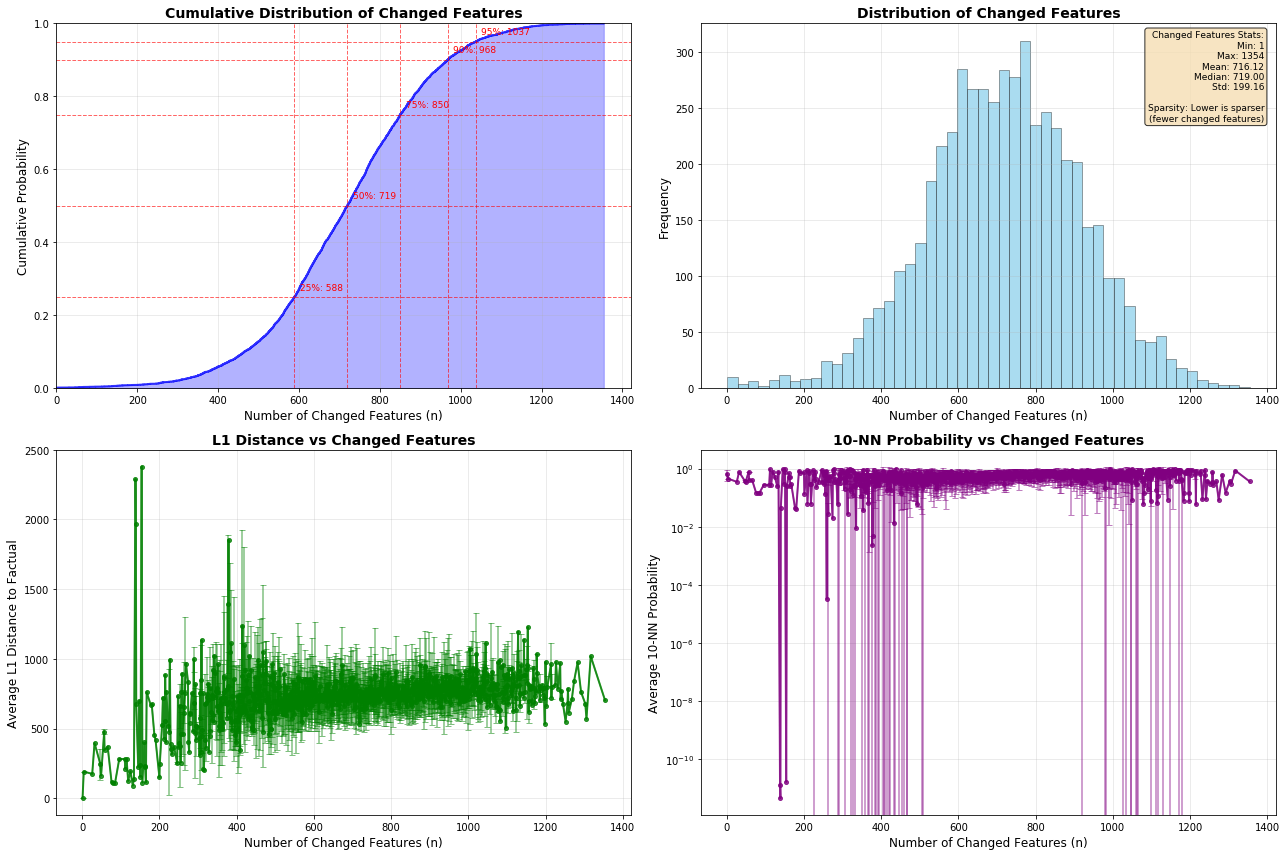

Comprehensive plot saved to sparsity_cdf.png

Changed Features Analysis by Class:

Class 0.0 (5208 samples):
  Changed features - Min: 1, Max: 1354
  Changed features - Mean: 716.12, Median: 719.00
  Identical features - Min: 18533, Max: 19886
  Identical features - Mean: 19170.88, Median: 19168.00

Top 10 Most Sparse Counterfactuals (Fewest Changed Features):
CF Index: 90.0, Original Index: 6415.0, Changed Features: 1.0, Identical Features: 19886.0, Class: 0.0
CF Index: 91.0, Original Index: 6415.0, Changed Features: 1.0, Identical Features: 19886.0, Class: 0.0
CF Index: 92.0, Original Index: 6415.0, Changed Features: 1.0, Identical Features: 19886.0, Class: 0.0
CF Index: 1986.0, Original Index: 6838.0, Changed Features: 1.0, Identical Features: 19886.0, Class: 0.0
CF Index: 1987.0, Original Index: 6838.0, Changed Features: 1.0, Identical Features: 19886.0, Class: 0.0
CF Index: 1988.0, Original Index: 6838.0, Changed Features: 1.0, Identical Features: 19886.0, Class: 0.0
CF Index: 240

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import math

def compute_gaussian_probability(distance, mean, variance):
    """
    Compute the probability P(abs(x-mean) > abs(distance-mean))
    This gives the probability of being further from the mean than this distance
    """
    # Calculate how far we are from the mean
    distance_from_mean = abs(distance - mean)
    
    # Compute the probability of being further from the mean (one-sided)
    # This is equivalent to 2 * (1 - CDF(|x-mean|))
    z_score = distance_from_mean / math.sqrt(variance)
    probability = 2 * (1 - 0.5 * (1 + math.erf(z_score / math.sqrt(2))))
    
    return probability

def compute_10nn_probability_gpu(
    cf_features, 
    original_features, 
    dataset_gaussian_mean=8304.722022, 
    dataset_gaussian_variance=4707926.898804,
    batch_size=512
):
    """
    Compute 10-NN probabilities for counterfactuals using GPU acceleration
    
    Args:
        cf_features: Counterfactual features tensor on GPU
        original_features: Original dataset features tensor on GPU
        dataset_gaussian_mean: Mean for Gaussian probability calculation
        dataset_gaussian_variance: Variance for Gaussian probability calculation
        batch_size: Batch size for processing
        
    Returns:
        List of 10-NN probabilities
    """
    device = cf_features.device
    probabilities = []
    
    # Process counterfactuals in batches
    for start_idx in range(0, len(cf_features), batch_size):
        end_idx = min(start_idx + batch_size, len(cf_features))
        batch_cf = cf_features[start_idx:end_idx]
        
        # Initialize storage for 10-NN distances
        k = 11  # k+1 to avoid counting self (though unlikely to be exact match)
        knn_distances = torch.full((len(batch_cf), k), float('inf'), device=device)
        
        # Process original data in chunks
        chunk_size = 5000  # Adjust based on available GPU memory
        for chunk_start in range(0, len(original_features), chunk_size):
            chunk_end = min(chunk_start + chunk_size, len(original_features))
            data_chunk = original_features[chunk_start:chunk_end]
            
            # Compute pairwise L1 distances between batch_cf and this chunk
            distances = torch.cdist(batch_cf, data_chunk, p=1)
            
            # Update top-k distances
            combined = torch.cat([knn_distances, distances], dim=1)
            topk_values, _ = torch.topk(combined, k=k, dim=1, largest=False)
            knn_distances = topk_values
        
        # Calculate average 10-NN distance for each counterfactual
        # Skip the first one (potentially self) and take the next 10
        avg_10nn_distances = torch.mean(knn_distances[:, 1:11], dim=1)
        
        # Compute the Gaussian probability for each distance
        for dist in avg_10nn_distances.cpu().numpy():
            prob = compute_gaussian_probability(dist, dataset_gaussian_mean, dataset_gaussian_variance)
            probabilities.append(prob)
    
    return probabilities

def compute_changed_features(
    original_data_path,
    sparse_counterfactuals_path,
    tolerance=1e-6,
    output_path='sparsity_analysis.parquet',
    plot_path='sparsity_cdf.png',
    compute_additional_metrics=True,
    gpu_id=0
):
    """
    Compute the number of changed features for each sparse counterfactual
    and generate cumulative distribution analysis with additional metrics
    
    Args:
        original_data_path: Path to original normalized data (data_eval_norm.parquet)
        sparse_counterfactuals_path: Path to sparse counterfactuals
        tolerance: Numerical tolerance for feature comparison
        output_path: Path to save detailed analysis results
        plot_path: Path to save the CDF plot
        compute_additional_metrics: Whether to compute L1 distance and 10-NN probability
        gpu_id: GPU device ID to use
        
    Returns:
        Tuple of (n_values, cdf_values, analysis_df) or (n_values, cdf_values, analysis_df, l1_values, prob_values)
    """
    # Set device
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    print("Loading data...")
    
    # Load original data and sparse counterfactuals
    original_data = pd.read_parquet(original_data_path)
    sparse_cfs = pd.read_parquet(sparse_counterfactuals_path)
    
    print(f"Original data shape: {original_data.shape}")
    print(f"Sparse counterfactuals shape: {sparse_cfs.shape}")
    
    # Extract feature names (assuming first column is class, last column is original_index)
    feature_names = list(original_data.columns)[1:]  # Exclude class column
    num_features = len(feature_names)
    print(f"Number of features: {num_features}")
    
    # Check the index ranges for diagnostics
    max_original_idx = sparse_cfs['original_index'].max()
    min_original_idx = sparse_cfs['original_index'].min()
    original_data_indices = set(original_data.index)
    
    print(f"Original data index range: {original_data.index.min()} to {original_data.index.max()}")
    print(f"Sparse CFs original_index range: {min_original_idx} to {max_original_idx}")
    print(f"Original data has {len(original_data)} rows with indices")
    
    # Check how many counterfactuals can be matched
    cf_indices = set(sparse_cfs['original_index'].astype(int))
    matchable_indices = cf_indices.intersection(original_data_indices)
    print(f"Counterfactuals reference {len(cf_indices)} unique indices")
    print(f"Matchable indices: {len(matchable_indices)}")
    
    if len(matchable_indices) < len(cf_indices):
        unmatched = cf_indices - original_data_indices
        print(f"WARNING: {len(unmatched)} indices cannot be matched")
        print(f"Sample unmatched indices: {sorted(list(unmatched))[:10]}")
    
    # Initialize results
    changed_features_count = []
    l1_distances = []
    ten_nn_probabilities = []
    detailed_results = []
    skipped_count = 0
    
    # Convert data to GPU tensors for faster computation if computing additional metrics
    if compute_additional_metrics:
        print("Converting data to GPU tensors...")
        # Convert all original data features to GPU tensor
        original_features_gpu = torch.tensor(
            original_data[feature_names].values, 
            dtype=torch.float32, 
            device=device
        )
        
        # Convert all sparse counterfactual features to GPU tensor  
        sparse_cf_features_gpu = torch.tensor(
            sparse_cfs[feature_names].values,
            dtype=torch.float32,
            device=device
        )
        
        print("Computing 10-NN probabilities...")
        # Compute 10-NN probabilities for all counterfactuals at once
        all_10nn_probs = compute_10nn_probability_gpu(
            sparse_cf_features_gpu, 
            original_features_gpu,
            batch_size=512
        )
    
    print(f"Processing {len(sparse_cfs)} counterfactuals...")
    
    # Process each counterfactual
    for idx, row in tqdm(sparse_cfs.iterrows(), total=len(sparse_cfs)):
        # Get the original index (this is a DataFrame index, not positional)
        original_idx = int(row['original_index'])
        
        try:
            # Use .loc to access by index rather than .iloc for position
            original_sample = original_data.loc[original_idx]
        except KeyError:
            skipped_count += 1
            if skipped_count <= 5:  # Only print first few warnings
                print(f"Skipping CF {idx}: Cannot find original sample with index {original_idx}")
            continue
        
        # Extract feature values
        cf_features = row[feature_names].values
        original_features = original_sample[feature_names].values
        
        # Compute absolute differences
        differences = np.abs(cf_features - original_features)
        
        # Count features that are different (beyond tolerance)
        changed_mask = differences > tolerance
        n_changed = np.sum(changed_mask)
        
        changed_features_count.append(n_changed)
        
        # Compute L1 distance if requested
        if compute_additional_metrics:
            l1_distance = np.sum(differences)
            l1_distances.append(l1_distance)
            
            # Get precomputed 10-NN probability
            ten_nn_probabilities.append(all_10nn_probs[idx])
        
        # Store detailed results
        result_dict = {
            'cf_index': idx,
            'original_index': original_idx,
            'n_changed_features': n_changed,
            'n_identical_features': num_features - n_changed,
            'max_difference': np.max(differences),
            'mean_difference': np.mean(differences),
            'cf_class': row.iloc[0],  # First column is classification
        }
        
        if compute_additional_metrics:
            result_dict['l1_distance'] = l1_distance
            result_dict['10nn_probability'] = all_10nn_probs[idx]
        
        detailed_results.append(result_dict)
    
    print(f"\nProcessed {len(changed_features_count)} counterfactuals successfully")
    if skipped_count > 0:
        print(f"Skipped {skipped_count} counterfactuals due to missing original indices")
    
    # Convert to arrays
    n_values = np.array(changed_features_count)
    
    # Compute statistics
    print(f"\nChanged Features Statistics:")
    print(f"Min changed features: {np.min(n_values)}")
    print(f"Max changed features: {np.max(n_values)}")
    print(f"Mean changed features: {np.mean(n_values):.2f}")
    print(f"Median changed features: {np.median(n_values):.2f}")
    print(f"Standard deviation: {np.std(n_values):.2f}")
    
    # Also show identical features statistics
    n_identical = num_features - n_values
    print(f"\nIdentical Features Statistics:")
    print(f"Min identical features: {np.min(n_identical)}")
    print(f"Max identical features: {np.max(n_identical)}")
    print(f"Mean identical features: {np.mean(n_identical):.2f}")
    print(f"Median identical features: {np.median(n_identical):.2f}")
    
    if compute_additional_metrics:
        l1_values = np.array(l1_distances)
        prob_values = np.array(ten_nn_probabilities)
        
        print(f"\nL1 Distance Statistics:")
        print(f"Min L1 distance: {np.min(l1_values):.4f}")
        print(f"Max L1 distance: {np.max(l1_values):.4f}")
        print(f"Mean L1 distance: {np.mean(l1_values):.4f}")
        print(f"Median L1 distance: {np.median(l1_values):.4f}")
        
        print(f"\n10-NN Probability Statistics:")
        print(f"Min 10-NN probability: {np.min(prob_values):.6f}")
        print(f"Max 10-NN probability: {np.max(prob_values):.6f}")
        print(f"Mean 10-NN probability: {np.mean(prob_values):.6f}")
        print(f"Median 10-NN probability: {np.median(prob_values):.6f}")
    
    # Compute cumulative distribution for changed features
    unique_n_values = np.unique(n_values)
    cdf_values = np.zeros_like(unique_n_values, dtype=float)
    
    total_samples = len(n_values)
    for i, n in enumerate(unique_n_values):
        cdf_values[i] = np.sum(n_values <= n) / total_samples
    
    # Create detailed analysis DataFrame
    analysis_df = pd.DataFrame(detailed_results)
    
    # Save detailed results
    analysis_df.to_parquet(output_path)
    print(f"Detailed analysis saved to {output_path}")
    
    # Create and save plot
    if compute_additional_metrics:
        create_comprehensive_plot(
            unique_n_values, cdf_values, n_values, 
            l1_values, prob_values, analysis_df, plot_path
        )
    else:
        create_sparsity_plot(unique_n_values, cdf_values, n_values, plot_path)
    
    if compute_additional_metrics:
        return unique_n_values, cdf_values, analysis_df, l1_values, prob_values
    else:
        return unique_n_values, cdf_values, analysis_df

def create_comprehensive_plot(n_values, cdf_values, all_n_values, l1_values, prob_values, analysis_df, plot_path):
    """
    Create a comprehensive 4-panel analysis plot including L1 distance and 10-NN probability
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # Plot 1: Cumulative Distribution Function
    ax1.step(n_values, cdf_values, where='post', linewidth=2, color='blue', alpha=0.8)
    ax1.fill_between(n_values, cdf_values, alpha=0.3, color='blue', step='post')
    ax1.set_xlabel('Number of Changed Features (n)', fontsize=12)
    ax1.set_ylabel('Cumulative Probability', fontsize=12)
    ax1.set_title('Cumulative Distribution of Changed Features', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(left=0)
    ax1.set_ylim(0, 1)
    
    # Add percentile lines
    percentiles = [0.25, 0.5, 0.75, 0.9, 0.95]
    for p in percentiles:
        n_at_percentile = np.percentile(all_n_values, p * 100)
        ax1.axhline(y=p, color='red', linestyle='--', alpha=0.6, linewidth=1)
        ax1.axvline(x=n_at_percentile, color='red', linestyle='--', alpha=0.6, linewidth=1)
        ax1.text(n_at_percentile + max(n_values) * 0.01, p + 0.02, 
                f'{int(p*100)}%: {n_at_percentile:.0f}', 
                fontsize=9, color='red')
    
    # Plot 2: Histogram of Changed Features
    ax2.hist(all_n_values, bins=min(50, len(n_values)), alpha=0.7, color='skyblue', 
             edgecolor='black', linewidth=0.5)
    ax2.set_xlabel('Number of Changed Features (n)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Distribution of Changed Features', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add statistics text
    stats_text = f"""Changed Features Stats:
Min: {np.min(all_n_values)}
Max: {np.max(all_n_values)}
Mean: {np.mean(all_n_values):.2f}
Median: {np.median(all_n_values):.2f}
Std: {np.std(all_n_values):.2f}

Sparsity: Lower is sparser
(fewer changed features)"""
    
    ax2.text(0.98, 0.98, stats_text, transform=ax2.transAxes, 
             fontsize=9, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Plot 3: Average L1 Distance by Number of Changed Features
    # Group by number of changed features and compute average L1 distance
    df_grouped = analysis_df.groupby('n_changed_features').agg({
        'l1_distance': ['mean', 'std', 'count']
    }).reset_index()
    
    # Flatten column names
    df_grouped.columns = ['n_changed_features', 'l1_mean', 'l1_std', 'l1_count']
    
    # Filter to only include groups with multiple samples for better statistics
    df_grouped = df_grouped[df_grouped['l1_count'] >= 1]
    
    ax3.plot(df_grouped['n_changed_features'], df_grouped['l1_mean'], 
             'o-', color='green', linewidth=2, markersize=4, alpha=0.8)
    
    # Add error bars if we have std data
    if len(df_grouped) > 0:
        ax3.errorbar(df_grouped['n_changed_features'], df_grouped['l1_mean'], 
                    yerr=df_grouped['l1_std'], alpha=0.5, color='green', capsize=3)
    
    ax3.set_xlabel('Number of Changed Features (n)', fontsize=12)
    ax3.set_ylabel('Average L1 Distance to Factual', fontsize=12)
    ax3.set_title('L1 Distance vs Changed Features', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Average 10-NN Probability by Number of Changed Features
    df_prob_grouped = analysis_df.groupby('n_changed_features').agg({
        '10nn_probability': ['mean', 'std', 'count']
    }).reset_index()
    
    # Flatten column names
    df_prob_grouped.columns = ['n_changed_features', 'prob_mean', 'prob_std', 'prob_count']
    
    # Filter to only include groups with multiple samples
    df_prob_grouped = df_prob_grouped[df_prob_grouped['prob_count'] >= 1]
    
    ax4.plot(df_prob_grouped['n_changed_features'], df_prob_grouped['prob_mean'], 
             'o-', color='purple', linewidth=2, markersize=4, alpha=0.8)
    
    # Add error bars
    if len(df_prob_grouped) > 0:
        ax4.errorbar(df_prob_grouped['n_changed_features'], df_prob_grouped['prob_mean'], 
                    yerr=df_prob_grouped['prob_std'], alpha=0.5, color='purple', capsize=3)
    
    ax4.set_xlabel('Number of Changed Features (n)', fontsize=12)
    ax4.set_ylabel('Average 10-NN Probability', fontsize=12)
    ax4.set_title('10-NN Probability vs Changed Features', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')  # Log scale for probability values
    
    plt.tight_layout()
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Comprehensive plot saved to {plot_path}")

def create_sparsity_plot(n_values, cdf_values, all_n_values, plot_path):
    """
    Create a comprehensive analysis plot for changed features
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Cumulative Distribution Function
    ax1.step(n_values, cdf_values, where='post', linewidth=2, color='blue', alpha=0.8)
    ax1.fill_between(n_values, cdf_values, alpha=0.3, color='blue', step='post')
    ax1.set_xlabel('Number of Changed Features (n)', fontsize=12)
    ax1.set_ylabel('Cumulative Probability', fontsize=12)
    ax1.set_title('Cumulative Distribution of Changed Features', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(left=0)
    ax1.set_ylim(0, 1)
    
    # Add percentile lines
    percentiles = [0.25, 0.5, 0.75, 0.9, 0.95]
    for p in percentiles:
        n_at_percentile = np.percentile(all_n_values, p * 100)
        ax1.axhline(y=p, color='red', linestyle='--', alpha=0.6, linewidth=1)
        ax1.axvline(x=n_at_percentile, color='red', linestyle='--', alpha=0.6, linewidth=1)
        ax1.text(n_at_percentile + max(n_values) * 0.01, p + 0.02, 
                f'{int(p*100)}%: {n_at_percentile:.0f}', 
                fontsize=9, color='red')
    
    # Plot 2: Histogram
    ax2.hist(all_n_values, bins=min(50, len(n_values)), alpha=0.7, color='skyblue', 
             edgecolor='black', linewidth=0.5)
    ax2.set_xlabel('Number of Changed Features (n)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Distribution of Changed Features', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add statistics text
    stats_text = f"""Changed Features Stats:
Min: {np.min(all_n_values)}
Max: {np.max(all_n_values)}
Mean: {np.mean(all_n_values):.2f}
Median: {np.median(all_n_values):.2f}
Std: {np.std(all_n_values):.2f}

Sparsity: Lower is sparser
(fewer changed features)"""
    
    ax2.text(0.98, 0.98, stats_text, transform=ax2.transAxes, 
             fontsize=9, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to {plot_path}")

def analyze_sparsity_by_class(analysis_df):
    """
    Analyze changed features patterns by counterfactual class
    """
    print("\nChanged Features Analysis by Class:")
    print("=" * 50)
    
    for class_val in sorted(analysis_df['cf_class'].unique()):
        class_data = analysis_df[analysis_df['cf_class'] == class_val]
        n_changed = class_data['n_changed_features']
        n_identical = class_data['n_identical_features']
        
        print(f"\nClass {class_val} ({len(class_data)} samples):")
        print(f"  Changed features - Min: {np.min(n_changed)}, Max: {np.max(n_changed)}")
        print(f"  Changed features - Mean: {np.mean(n_changed):.2f}, Median: {np.median(n_changed):.2f}")
        print(f"  Identical features - Min: {np.min(n_identical)}, Max: {np.max(n_identical)}")
        print(f"  Identical features - Mean: {np.mean(n_identical):.2f}, Median: {np.median(n_identical):.2f}")

def get_most_sparse_examples(analysis_df, n_examples=10):
    """
    Get the most sparse counterfactuals (fewest changed features)
    """
    most_sparse = analysis_df.nsmallest(n_examples, 'n_changed_features')
    
    print(f"\nTop {n_examples} Most Sparse Counterfactuals (Fewest Changed Features):")
    print("=" * 70)
    for idx, row in most_sparse.iterrows():
        print(f"CF Index: {row['cf_index']}, "
              f"Original Index: {row['original_index']}, "
              f"Changed Features: {row['n_changed_features']}, "
              f"Identical Features: {row['n_identical_features']}, "
              f"Class: {row['cf_class']}")
    
    return most_sparse

# Main execution function
def run_sparsity_analysis(
    original_data_path='data_norm.parquet',
    sparse_counterfactuals_path='sparse_counterfactuals.parquet',
    tolerance=1e-6,
    compute_additional_metrics=True,
    gpu_id=0
):
    """
    Run complete sparsity analysis with optional additional metrics
    """
    # Compute changed features and generate CDF
    if compute_additional_metrics:
        n_values, cdf_values, analysis_df, l1_values, prob_values = compute_changed_features(
            original_data_path=original_data_path,
            sparse_counterfactuals_path=sparse_counterfactuals_path,
            tolerance=tolerance,
            compute_additional_metrics=True,
            gpu_id=gpu_id
        )
    else:
        n_values, cdf_values, analysis_df = compute_changed_features(
            original_data_path=original_data_path,
            sparse_counterfactuals_path=sparse_counterfactuals_path,
            tolerance=tolerance,
            compute_additional_metrics=False,
            gpu_id=gpu_id
        )
    
    # Additional analyses
    analyze_sparsity_by_class(analysis_df)
    most_sparse = get_most_sparse_examples(analysis_df)
    
    print(f"\nReturning:")
    print(f"- n_values: array of unique changed feature counts ({len(n_values)} values)")
    print(f"- cdf_values: corresponding cumulative probabilities")
    print(f"- analysis_df: detailed results DataFrame ({len(analysis_df)} rows)")
    if compute_additional_metrics:
        print(f"- l1_values: L1 distances to factuals")
        print(f"- prob_values: 10-NN probabilities")
    print(f"Note: Results show CHANGED features. Lower values = more sparse counterfactuals.")
    
    if compute_additional_metrics:
        return n_values, cdf_values, analysis_df, l1_values, prob_values
    else:
        return n_values, cdf_values, analysis_df

# Example usage:
# With additional metrics (GPU-accelerated):
n_vals, cdf_vals, results_df, l1_vals, prob_vals = run_sparsity_analysis(
    original_data_path='data_norm.parquet',
    sparse_counterfactuals_path='sparse_3cf_grad_desc.parquet',
    compute_additional_metrics=True,
    gpu_id=1
)


Running class 0 analysis with NO probability range restriction
Note: 10-NN computed against CLASS 0 samples only
Using device: cuda:1
Loading data...
Number of features: 19887
Found 669 class 0 samples out of 9349 total samples
Converting data to GPU tensors...
Computing 10-NN probabilities against class 0 samples...
Computing 10-NN against 669 class 0 samples...


  0%|          | 1/5208 [00:00<09:35,  9.04it/s]

Processing 5208 counterfactuals...


100%|██████████| 5208/5208 [03:41<00:00, 23.56it/s]


Processed 5208 counterfactuals
Grouped into 945 unique changed feature counts
Changed features range: 1 to 1354
10-NN class 0 probability range: 0.000000 to 0.955784


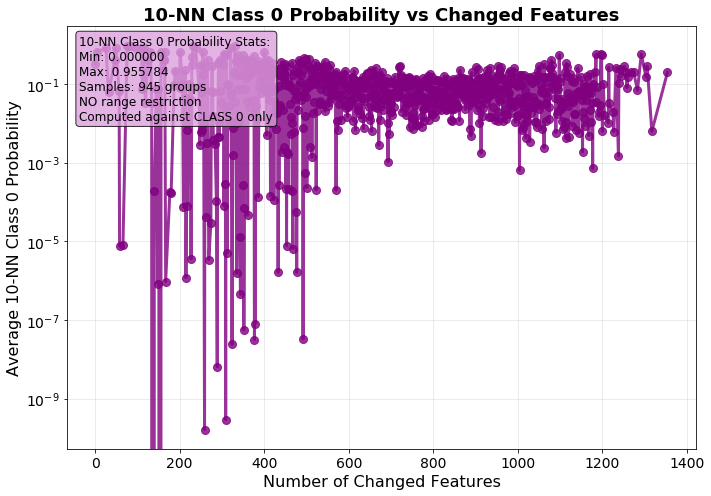

Class 0 10-NN plot saved to class0_10nn_plot.png

Results Summary:
- Feature change range: 1 to 1354
- 10-NN class 0 probability range: 0.000000 to 0.955784
- Number of unique feature change counts: 945
- 10-NN computed against CLASS 0 samples only using class 0 Gaussian parameters
- NO probability range restriction applied


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import math

def compute_gaussian_probability(distance, mean, variance):
    """
    Compute the probability P(abs(x-mean) > abs(distance-mean))
    This gives the probability of being further from the mean than this distance
    """
    # Calculate how far we are from the mean
    distance_from_mean = abs(distance - mean)
    
    # Compute the probability of being further from the mean (one-sided)
    # This is equivalent to 2 * (1 - CDF(|x-mean|))
    z_score = distance_from_mean / math.sqrt(variance)
    probability = 2 * (1 - 0.5 * (1 + math.erf(z_score / math.sqrt(2))))
    
    return probability

def compute_10nn_class0_probability_gpu(
    cf_features, 
    class0_features, 
    class0_gaussian_mean=5950.676427, 
    class0_gaussian_variance=3400381.504375,
    batch_size=512
):
    """
    Compute 10-NN probabilities for counterfactuals using only class 0 samples
    
    Args:
        cf_features: Counterfactual features tensor on GPU
        class0_features: Class 0 samples features tensor on GPU
        class0_gaussian_mean: Mean for class 0 Gaussian probability calculation
        class0_gaussian_variance: Variance for class 0 Gaussian probability calculation
        batch_size: Batch size for processing
        
    Returns:
        List of 10-NN probabilities computed against class 0 only
    """
    device = cf_features.device
    probabilities = []
    
    if len(class0_features) == 0:
        print("WARNING: No class 0 samples found!")
        return [0.0] * len(cf_features)
    
    print(f"Computing 10-NN against {len(class0_features)} class 0 samples...")
    
    # Process counterfactuals in batches
    for start_idx in range(0, len(cf_features), batch_size):
        end_idx = min(start_idx + batch_size, len(cf_features))
        batch_cf = cf_features[start_idx:end_idx]
        
        # Initialize storage for 10-NN distances
        k = min(11, len(class0_features))  # Cap at available class 0 samples
        knn_distances = torch.full((len(batch_cf), k), float('inf'), device=device)
        
        # Process class 0 data in chunks
        chunk_size = 5000
        for chunk_start in range(0, len(class0_features), chunk_size):
            chunk_end = min(chunk_start + chunk_size, len(class0_features))
            data_chunk = class0_features[chunk_start:chunk_end]
            
            # Compute pairwise L1 distances between counterfactuals and class 0 samples
            distances = torch.cdist(batch_cf, data_chunk, p=1)
            
            # Update top-k distances
            combined = torch.cat([knn_distances, distances], dim=1)
            topk_values, _ = torch.topk(combined, k=k, dim=1, largest=False)
            knn_distances = topk_values
        
        # Calculate average 10-NN distance for each counterfactual
        if k > 1:
            # Use as many neighbors as available after skipping the first one
            neighbors_to_use = min(10, k-1)
            avg_10nn_distances = torch.mean(knn_distances[:, 1:1+neighbors_to_use], dim=1)
        else:
            # If only one class 0 sample, use it
            avg_10nn_distances = knn_distances[:, 0]
        
        # Compute the Gaussian probability for each distance using class 0 parameters
        for dist in avg_10nn_distances.cpu().numpy():
            prob = compute_gaussian_probability(dist, class0_gaussian_mean, class0_gaussian_variance)
            probabilities.append(prob)
    
    return probabilities

def compute_class0_metrics_for_plotting(
    original_data_path,
    sparse_counterfactuals_path,
    tolerance=1e-6,
    gpu_id=0
):
    """
    Compute 10-NN probabilities against class 0 only for clean plotting
    
    Args:
        original_data_path: Path to original normalized data
        sparse_counterfactuals_path: Path to sparse counterfactuals
        tolerance: Numerical tolerance for feature comparison
        gpu_id: GPU device ID to use
        
    Returns:
        DataFrame with results ready for plotting (no probability filtering)
    """
    # Set device
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    print("Loading data...")
    original_data = pd.read_parquet(original_data_path)
    sparse_cfs = pd.read_parquet(sparse_counterfactuals_path)
    
    # Extract feature names
    feature_names = list(original_data.columns)[1:]  # Exclude class column
    num_features = len(feature_names)
    print(f"Number of features: {num_features}")
    
    # Filter to get only class 0 samples from original data
    class0_mask = original_data.iloc[:, 0] == 0  # First column is class
    class0_data = original_data[class0_mask]
    print(f"Found {len(class0_data)} class 0 samples out of {len(original_data)} total samples")
    
    if len(class0_data) == 0:
        print("ERROR: No class 0 samples found in original data!")
        return None
    
    # Convert data to GPU tensors
    print("Converting data to GPU tensors...")
    class0_features_gpu = torch.tensor(
        class0_data[feature_names].values, 
        dtype=torch.float32, 
        device=device
    )
    
    sparse_cf_features_gpu = torch.tensor(
        sparse_cfs[feature_names].values,
        dtype=torch.float32,
        device=device
    )
    
    print("Computing 10-NN probabilities against class 0 samples...")
    all_10nn_probs = compute_10nn_class0_probability_gpu(
        sparse_cf_features_gpu, 
        class0_features_gpu,
        batch_size=512
    )
    
    # Process each counterfactual
    results = []
    skipped_count = 0
    
    print(f"Processing {len(sparse_cfs)} counterfactuals...")
    for idx, row in tqdm(sparse_cfs.iterrows(), total=len(sparse_cfs)):
        original_idx = int(row['original_index'])
        
        try:
            original_sample = original_data.loc[original_idx]
        except KeyError:
            skipped_count += 1
            continue
        
        # Extract feature values
        cf_features = row[feature_names].values
        original_features = original_sample[feature_names].values
        
        # Compute differences and metrics
        differences = np.abs(cf_features - original_features)
        changed_mask = differences > tolerance
        n_changed = np.sum(changed_mask)
        prob_10nn = all_10nn_probs[idx]
        
        # Store all results (no probability filtering)
        results.append({
            'n_changed_features': n_changed,
            '10nn_class0_probability': prob_10nn
        })
    
    print(f"Processed {len(results)} counterfactuals")
    if skipped_count > 0:
        print(f"Skipped {skipped_count} counterfactuals due to missing indices")
    
    # Create DataFrame (no probability filtering)
    df = pd.DataFrame(results)
    
    if len(df) == 0:
        print("WARNING: No samples found!")
        return None
    
    # Group by number of changed features and compute means
    grouped_data = df.groupby('n_changed_features').agg({
        '10nn_class0_probability': 'mean'
    }).reset_index()
    
    print(f"Grouped into {len(grouped_data)} unique changed feature counts")
    print(f"Changed features range: {grouped_data['n_changed_features'].min()} to {grouped_data['n_changed_features'].max()}")
    print(f"10-NN class 0 probability range: {grouped_data['10nn_class0_probability'].min():.6f} to {grouped_data['10nn_class0_probability'].max():.6f}")
    
    return grouped_data

def create_class0_plot(grouped_data, output_path='class0_10nn_plot.png'):
    """
    Create clean plot for 10-NN class 0 probability without variance bars
    
    Args:
        grouped_data: DataFrame with grouped results
        output_path: Path to save the plot
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    
    # Plot: Average 10-NN Class 0 Probability vs Changed Features  
    ax.plot(grouped_data['n_changed_features'], grouped_data['10nn_class0_probability'], 
            'o-', color='purple', linewidth=3, markersize=8, alpha=0.8)
    
    ax.set_xlabel('Number of Changed Features', fontsize=16)
    ax.set_ylabel('Average 10-NN Class 0 Probability', fontsize=16)
    ax.set_title('10-NN Class 0 Probability vs Changed Features', fontsize=18, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Add statistics text
    prob_stats = f"""10-NN Class 0 Probability Stats:
Min: {grouped_data['10nn_class0_probability'].min():.6f}
Max: {grouped_data['10nn_class0_probability'].max():.6f}
Samples: {len(grouped_data)} groups
NO range restriction
Computed against CLASS 0 only"""
    
    ax.text(0.02, 0.98, prob_stats, transform=ax.transAxes, 
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='plum', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Class 0 10-NN plot saved to {output_path}")

def run_class0_analysis(
    original_data_path='data_norm.parquet',
    sparse_counterfactuals_path='sparse_counterfactuals.parquet',
    tolerance=1e-6,
    gpu_id=0,
    output_path='class0_10nn_plot.png'
):
    """
    Run analysis and create plot for 10-NN class 0 probability without variance bars
    
    Args:
        original_data_path: Path to original data
        sparse_counterfactuals_path: Path to sparse counterfactuals  
        tolerance: Tolerance for changed features detection
        gpu_id: GPU device ID
        output_path: Path to save plot
        
    Returns:
        DataFrame with grouped results
    """
    print("Running class 0 analysis with NO probability range restriction")
    print("Note: 10-NN computed against CLASS 0 samples only")
    
    # Compute metrics without probability filtering
    grouped_data = compute_class0_metrics_for_plotting(
        original_data_path=original_data_path,
        sparse_counterfactuals_path=sparse_counterfactuals_path,
        tolerance=tolerance,
        gpu_id=gpu_id
    )
    
    if grouped_data is None:
        print("No data to plot!")
        return None
    
    # Create clean plot
    create_class0_plot(grouped_data, output_path)
    
    print(f"\nResults Summary:")
    print(f"- Feature change range: {grouped_data['n_changed_features'].min()} to {grouped_data['n_changed_features'].max()}")
    print(f"- 10-NN class 0 probability range: {grouped_data['10nn_class0_probability'].min():.6f} to {grouped_data['10nn_class0_probability'].max():.6f}")
    print(f"- Number of unique feature change counts: {len(grouped_data)}")
    print("- 10-NN computed against CLASS 0 samples only using class 0 Gaussian parameters")
    print("- NO probability range restriction applied")
    
    return grouped_data

# Example usage:
grouped_results = run_class0_analysis(
    original_data_path='data_norm.parquet',
    sparse_counterfactuals_path='sparse_3cf_grad_desc.parquet',
    gpu_id=1,
    output_path='class0_10nn_plot.png'
)


Running class 0 analysis with probability range [0.05, 1.0]
Note: 10-NN computed against CLASS 0 samples only
Using device: cuda:1
Loading data...
Number of features: 19887
Found 669 class 0 samples out of 9349 total samples
Converting data to GPU tensors...
Computing 10-NN probabilities against class 0 samples...
Computing 10-NN against 669 class 0 samples...


  0%|          | 1/5208 [00:00<10:36,  8.18it/s]

Processing 5208 counterfactuals...


100%|██████████| 5208/5208 [03:41<00:00, 23.53it/s]


Processed 1681 counterfactuals (filtered by probability range)
Grouped into 735 unique changed feature counts
Changed features range: 1 to 1354
10-NN class 0 probability range: 0.051537 to 0.955784


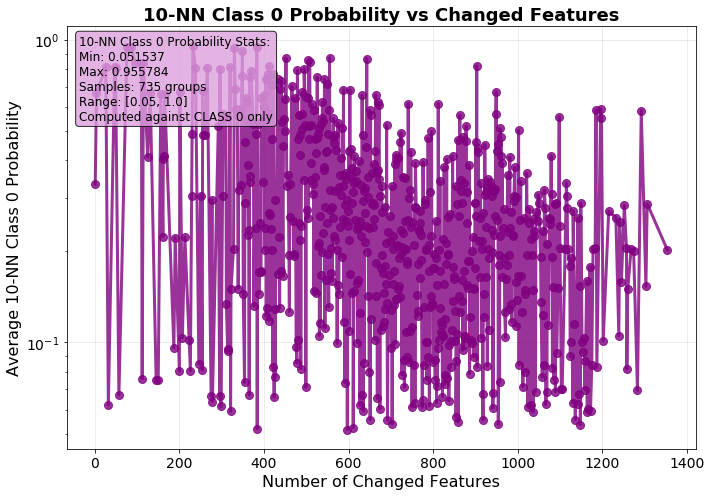

Class 0 10-NN plot saved to class0_10nn_plot.png

Results Summary:
- Feature change range: 1 to 1354
- 10-NN class 0 probability range: 0.051537 to 0.955784
- Number of unique feature change counts: 735
- 10-NN computed against CLASS 0 samples only using class 0 Gaussian parameters


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import math

def compute_gaussian_probability(distance, mean, variance):
    """
    Compute the probability P(abs(x-mean) > abs(distance-mean))
    This gives the probability of being further from the mean than this distance
    """
    # Calculate how far we are from the mean
    distance_from_mean = abs(distance - mean)
    
    # Compute the probability of being further from the mean (one-sided)
    # This is equivalent to 2 * (1 - CDF(|x-mean|))
    z_score = distance_from_mean / math.sqrt(variance)
    probability = 2 * (1 - 0.5 * (1 + math.erf(z_score / math.sqrt(2))))
    
    return probability

def compute_10nn_class0_probability_gpu(
    cf_features, 
    class0_features, 
    class0_gaussian_mean=5950.676427, 
    class0_gaussian_variance=3400381.504375,
    batch_size=512
):
    """
    Compute 10-NN probabilities for counterfactuals using only class 0 samples
    
    Args:
        cf_features: Counterfactual features tensor on GPU
        class0_features: Class 0 samples features tensor on GPU
        class0_gaussian_mean: Mean for class 0 Gaussian probability calculation
        class0_gaussian_variance: Variance for class 0 Gaussian probability calculation
        batch_size: Batch size for processing
        
    Returns:
        List of 10-NN probabilities computed against class 0 only
    """
    device = cf_features.device
    probabilities = []
    
    if len(class0_features) == 0:
        print("WARNING: No class 0 samples found!")
        return [0.0] * len(cf_features)
    
    print(f"Computing 10-NN against {len(class0_features)} class 0 samples...")
    
    # Process counterfactuals in batches
    for start_idx in range(0, len(cf_features), batch_size):
        end_idx = min(start_idx + batch_size, len(cf_features))
        batch_cf = cf_features[start_idx:end_idx]
        
        # Initialize storage for 10-NN distances
        k = min(11, len(class0_features))  # Cap at available class 0 samples
        knn_distances = torch.full((len(batch_cf), k), float('inf'), device=device)
        
        # Process class 0 data in chunks
        chunk_size = 5000
        for chunk_start in range(0, len(class0_features), chunk_size):
            chunk_end = min(chunk_start + chunk_size, len(class0_features))
            data_chunk = class0_features[chunk_start:chunk_end]
            
            # Compute pairwise L1 distances between counterfactuals and class 0 samples
            distances = torch.cdist(batch_cf, data_chunk, p=1)
            
            # Update top-k distances
            combined = torch.cat([knn_distances, distances], dim=1)
            topk_values, _ = torch.topk(combined, k=k, dim=1, largest=False)
            knn_distances = topk_values
        
        # Calculate average 10-NN distance for each counterfactual
        if k > 1:
            # Use as many neighbors as available after skipping the first one
            neighbors_to_use = min(10, k-1)
            avg_10nn_distances = torch.mean(knn_distances[:, 1:1+neighbors_to_use], dim=1)
        else:
            # If only one class 0 sample, use it
            avg_10nn_distances = knn_distances[:, 0]
        
        # Compute the Gaussian probability for each distance using class 0 parameters
        for dist in avg_10nn_distances.cpu().numpy():
            prob = compute_gaussian_probability(dist, class0_gaussian_mean, class0_gaussian_variance)
            probabilities.append(prob)
    
    return probabilities

def compute_class0_metrics_for_plotting(
    original_data_path,
    sparse_counterfactuals_path,
    tolerance=1e-6,
    gpu_id=0,
    prob_min=0.001,
    prob_max=1.0
):
    """
    Compute 10-NN probabilities against class 0 only for clean plotting
    
    Args:
        original_data_path: Path to original normalized data
        sparse_counterfactuals_path: Path to sparse counterfactuals
        tolerance: Numerical tolerance for feature comparison
        gpu_id: GPU device ID to use
        prob_min: Minimum probability threshold (default 0.05)
        prob_max: Maximum probability threshold (default 1.0)
        
    Returns:
        DataFrame with filtered results ready for plotting
    """
    # Set device
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    print("Loading data...")
    original_data = pd.read_parquet(original_data_path)
    sparse_cfs = pd.read_parquet(sparse_counterfactuals_path)
    
    # Extract feature names
    feature_names = list(original_data.columns)[1:]  # Exclude class column
    num_features = len(feature_names)
    print(f"Number of features: {num_features}")
    
    # Filter to get only class 0 samples from original data
    class0_mask = original_data.iloc[:, 0] == 0  # First column is class
    class0_data = original_data[class0_mask]
    print(f"Found {len(class0_data)} class 0 samples out of {len(original_data)} total samples")
    
    if len(class0_data) == 0:
        print("ERROR: No class 0 samples found in original data!")
        return None
    
    # Convert data to GPU tensors
    print("Converting data to GPU tensors...")
    class0_features_gpu = torch.tensor(
        class0_data[feature_names].values, 
        dtype=torch.float32, 
        device=device
    )
    
    sparse_cf_features_gpu = torch.tensor(
        sparse_cfs[feature_names].values,
        dtype=torch.float32,
        device=device
    )
    
    print("Computing 10-NN probabilities against class 0 samples...")
    all_10nn_probs = compute_10nn_class0_probability_gpu(
        sparse_cf_features_gpu, 
        class0_features_gpu,
        batch_size=512
    )
    
    # Process each counterfactual
    results = []
    skipped_count = 0
    
    print(f"Processing {len(sparse_cfs)} counterfactuals...")
    for idx, row in tqdm(sparse_cfs.iterrows(), total=len(sparse_cfs)):
        original_idx = int(row['original_index'])
        
        try:
            original_sample = original_data.loc[original_idx]
        except KeyError:
            skipped_count += 1
            continue
        
        # Extract feature values
        cf_features = row[feature_names].values
        original_features = original_sample[feature_names].values
        
        # Compute differences and metrics
        differences = np.abs(cf_features - original_features)
        changed_mask = differences > tolerance
        n_changed = np.sum(changed_mask)
        prob_10nn = all_10nn_probs[idx]
        
        # Apply probability filter
        if prob_min <= prob_10nn <= prob_max:
            results.append({
                'n_changed_features': n_changed,
                '10nn_class0_probability': prob_10nn
            })
    
    print(f"Processed {len(results)} counterfactuals (filtered by probability range)")
    if skipped_count > 0:
        print(f"Skipped {skipped_count} counterfactuals due to missing indices")
    
    # Create DataFrame and filter by probability range
    df = pd.DataFrame(results)
    
    if len(df) == 0:
        print("WARNING: No samples remain after probability filtering!")
        return None
    
    # Group by number of changed features and compute means
    grouped_data = df.groupby('n_changed_features').agg({
        '10nn_class0_probability': 'mean'
    }).reset_index()
    
    print(f"Grouped into {len(grouped_data)} unique changed feature counts")
    print(f"Changed features range: {grouped_data['n_changed_features'].min()} to {grouped_data['n_changed_features'].max()}")
    print(f"10-NN class 0 probability range: {grouped_data['10nn_class0_probability'].min():.6f} to {grouped_data['10nn_class0_probability'].max():.6f}")
    
    return grouped_data

def create_class0_plot(grouped_data, output_path='class0_10nn_plot.png'):
    """
    Create clean plot for 10-NN class 0 probability without variance bars
    
    Args:
        grouped_data: DataFrame with grouped results
        output_path: Path to save the plot
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    
    # Plot: Average 10-NN Class 0 Probability vs Changed Features  
    ax.plot(grouped_data['n_changed_features'], grouped_data['10nn_class0_probability'], 
            'o-', color='purple', linewidth=3, markersize=8, alpha=0.8)
    
    ax.set_xlabel('Number of Changed Features', fontsize=16)
    ax.set_ylabel('Average 10-NN Class 0 Probability', fontsize=16)
    ax.set_title('10-NN Class 0 Probability vs Changed Features', fontsize=18, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Add statistics text
    prob_stats = f"""10-NN Class 0 Probability Stats:
Min: {grouped_data['10nn_class0_probability'].min():.6f}
Max: {grouped_data['10nn_class0_probability'].max():.6f}
Samples: {len(grouped_data)} groups
Range: [0.05, 1.0]
Computed against CLASS 0 only"""
    
    ax.text(0.02, 0.98, prob_stats, transform=ax.transAxes, 
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='plum', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Class 0 10-NN plot saved to {output_path}")

def run_class0_analysis(
    original_data_path='data_norm.parquet',
    sparse_counterfactuals_path='sparse_counterfactuals.parquet',
    tolerance=1e-6,
    gpu_id=0,
    prob_min=0.05,
    prob_max=1.0,
    output_path='class0_10nn_plot.png'
):
    """
    Run analysis and create plot for 10-NN class 0 probability without variance bars
    
    Args:
        original_data_path: Path to original data
        sparse_counterfactuals_path: Path to sparse counterfactuals  
        tolerance: Tolerance for changed features detection
        gpu_id: GPU device ID
        prob_min: Minimum 10-NN probability to include (default 0.05)
        prob_max: Maximum 10-NN probability to include (default 1.0)
        output_path: Path to save plot
        
    Returns:
        DataFrame with grouped results
    """
    print(f"Running class 0 analysis with probability range [{prob_min}, {prob_max}]")
    print("Note: 10-NN computed against CLASS 0 samples only")
    
    # Compute metrics with probability filtering
    grouped_data = compute_class0_metrics_for_plotting(
        original_data_path=original_data_path,
        sparse_counterfactuals_path=sparse_counterfactuals_path,
        tolerance=tolerance,
        gpu_id=gpu_id,
        prob_min=prob_min,
        prob_max=prob_max
    )
    
    if grouped_data is None:
        print("No data to plot after filtering!")
        return None
    
    # Create clean plot
    create_class0_plot(grouped_data, output_path)
    
    print(f"\nResults Summary:")
    print(f"- Feature change range: {grouped_data['n_changed_features'].min()} to {grouped_data['n_changed_features'].max()}")
    print(f"- 10-NN class 0 probability range: {grouped_data['10nn_class0_probability'].min():.6f} to {grouped_data['10nn_class0_probability'].max():.6f}")
    print(f"- Number of unique feature change counts: {len(grouped_data)}")
    print("- 10-NN computed against CLASS 0 samples only using class 0 Gaussian parameters")
    
    return grouped_data

# Example usage:
grouped_results = run_class0_analysis(
    original_data_path='data_norm.parquet',
    sparse_counterfactuals_path='sparse_3cf_grad_desc.parquet',
    prob_min=0.05,
    prob_max=1.0,
    gpu_id=1,
    output_path='class0_10nn_plot.png'
)

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from datetime import datetime, timedelta
from torch.utils.data import DataLoader, TensorDataset

class MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2000)
        self.bn1 = nn.BatchNorm1d(2000)
        self.dropout1 = nn.Dropout(0.02)
        self.fc2 = nn.Linear(2000, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.dropout2 = nn.Dropout(0.02)
        self.fc3 = nn.Linear(200, 20)
        self.bn3 = nn.BatchNorm1d(20)
        self.dropout3 = nn.Dropout(0.02)
        self.fc4 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()
        self.leaky_relu = nn.LeakyReLU(0.01)
        
    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.sigmoid(self.fc4(x))
        return x

def load_model(model_path, input_size, device):
    """Load the pretrained MLP model"""
    model = MLP(input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def efficient_knn_distances(candidates, reference_data, device, chunk_size=32, k=10):
    """Memory-efficient k-NN computation with small chunks"""
    n_candidates = candidates.shape[0]
    n_reference = reference_data.shape[0]
    k = min(k, n_reference)
    
    knn_distances = torch.zeros(n_candidates, device=device)
    
    for i in range(0, n_candidates, chunk_size):
        end_i = min(i + chunk_size, n_candidates)
        candidate_chunk = candidates[i:end_i]
        
        chunk_expanded = candidate_chunk.unsqueeze(1)
        reference_expanded = reference_data.unsqueeze(0)
        
        distances = torch.sum(torch.abs(chunk_expanded - reference_expanded), dim=2)
        topk_distances, _ = torch.topk(distances, k, dim=1, largest=False)
        knn_distances[i:end_i] = topk_distances.mean(dim=1)
        
        del chunk_expanded, distances, topk_distances
    
    return knn_distances

class AdvancedProgressTracker:
    """Advanced progress tracking with detailed time estimates and statistics"""
    
    def __init__(self, total_items, item_name, update_interval=5.0):
        self.total_items = total_items
        self.item_name = item_name
        self.update_interval = update_interval
        self.start_time = time.time()
        self.last_update_time = self.start_time
        self.completed_items = 0
        self.speed_history = []
        self.max_history = 20  # Keep last 20 speed measurements for smoothing
        
        # Display startup info
        print("=" * 80)
        print(f"🚀 STARTING {item_name.upper()} COMPUTATION")
        print("=" * 80)
        print(f"Total {item_name}: {self.total_items:,}")
        print(f"Started at: {datetime.now().strftime('%H:%M:%S')}")
        print("-" * 80)
    
    def update(self, completed_items):
        """Update progress with detailed time estimates"""
        self.completed_items = completed_items
        current_time = time.time()
        
        # Update at specified intervals
        if current_time - self.last_update_time >= self.update_interval:
            elapsed_time = current_time - self.start_time
            
            if self.completed_items > 0:
                # Calculate current speed
                current_speed = self.completed_items / elapsed_time
                self.speed_history.append(current_speed)
                
                # Keep only recent history for smoothing
                if len(self.speed_history) > self.max_history:
                    self.speed_history = self.speed_history[-self.max_history:]
                
                # Use smoothed speed for better estimates
                avg_speed = sum(self.speed_history) / len(self.speed_history)
                
                # Calculate progress and time estimates
                progress_pct = (self.completed_items / self.total_items) * 100
                remaining_items = self.total_items - self.completed_items
                
                if avg_speed > 0:
                    eta_seconds = remaining_items / avg_speed
                    total_time_estimate = self.total_items / avg_speed
                    
                    # Format time strings
                    eta_str = self._format_time(eta_seconds)
                    total_str = self._format_time(total_time_estimate)
                    elapsed_str = self._format_time(elapsed_time)
                    
                    # Create progress bar
                    bar_length = 40
                    filled_length = int(bar_length * progress_pct / 100)
                    bar = '█' * filled_length + '░' * (bar_length - filled_length)
                    
                    # Calculate completion time
                    completion_time = datetime.now() + timedelta(seconds=eta_seconds)
                    
                    # Dynamic update line
                    progress_line = (
                        f"\r{progress_pct:6.2f}% [{bar}] "
                        f"{self.completed_items:,}/{self.total_items:,} {self.item_name} | "
                        f"Elapsed: {elapsed_str} | ETA: {eta_str} | "
                        f"Speed: {avg_speed:.0f}/sec | "
                        f"Finish: {completion_time.strftime('%H:%M:%S')}"
                    )
                    
                    print(progress_line, end='', flush=True)
                else:
                    print(f"\rInitializing... {self.completed_items:,} {self.item_name} processed", end='', flush=True)
            
            self.last_update_time = current_time
    
    def _format_time(self, seconds):
        """Format seconds into human-readable time string"""
        if seconds < 60:
            return f"{seconds:.0f}s"
        elif seconds < 3600:
            minutes = seconds / 60
            return f"{minutes:.1f}m"
        else:
            hours = seconds / 3600
            return f"{hours:.1f}h"
    
    def finish(self):
        """Print completion summary"""
        print()  # New line after progress bar
        total_time = time.time() - self.start_time
        final_speed = self.total_items / total_time if total_time > 0 else 0
        
        print("=" * 80)
        print(f"✅ {self.item_name.upper()} COMPLETED!")
        print("-" * 80)
        print(f"Total time: {self._format_time(total_time)}")
        print(f"Final speed: {final_speed:.0f} {self.item_name}/second")
        print(f"Completed at: {datetime.now().strftime('%H:%M:%S')}")
        print("=" * 80)

def precompute_all_predictions(X_eval, all_feature_samples, model, device, 
                               num_points, batch_size=512, save_path=None):
    """
    GAME CHANGER: Precompute ALL predictions for ALL feature variations
    
    This transforms the problem from:
    - 863M individual model calls (super slow)
    - To: ~86M predictions in large efficient batches (much faster)
    """
    n_samples, n_features = X_eval.shape
    total_predictions = n_samples * n_features * num_points
    
    print(f"🚀 PRECOMPUTING ALL PREDICTIONS...")
    print(f"Samples: {n_samples:,} | Features: {n_features:,} | Points: {num_points}")
    print(f"Total predictions needed: {total_predictions:,}")
    print(f"Memory required: ~{total_predictions * 4 / 1e9:.1f}GB")
    print()
    
    # Storage for all predictions: (n_samples, n_features, num_points)
    all_predictions = torch.zeros(n_samples, n_features, num_points, device='cpu')
    
    # Initialize progress tracker for samples
    sample_tracker = AdvancedProgressTracker(n_samples, "samples", update_interval=3.0)
    
    processed_predictions = 0
    
    # Process each sample
    for sample_idx in range(n_samples):
        sample = X_eval[sample_idx:sample_idx+1]  # (1, n_features)
        
        # Create ALL candidates for this sample at once
        sample_candidates = []
        
        for feature_idx in range(n_features):
            # Create candidates for this feature
            feature_samples = all_feature_samples[feature_idx]
            candidates_for_feature = sample.repeat(num_points, 1)  # (num_points, n_features)
            candidates_for_feature[:, feature_idx] = feature_samples
            sample_candidates.append(candidates_for_feature)
        
        # Stack all candidates for this sample: (n_features * num_points, n_features)
        all_sample_candidates = torch.cat(sample_candidates, dim=0)
        
        # Batch predict ALL candidates for this sample
        sample_predictions = torch.zeros(all_sample_candidates.shape[0], device=device)
        
        for i in range(0, all_sample_candidates.shape[0], batch_size):
            end_i = min(i + batch_size, all_sample_candidates.shape[0])
            batch_candidates = all_sample_candidates[i:end_i].to(device)
            
            with torch.no_grad():
                batch_preds = model(batch_candidates).squeeze()
                if batch_preds.dim() == 0:
                    batch_preds = batch_preds.unsqueeze(0)
                sample_predictions[i:end_i] = batch_preds
            
            del batch_candidates
        
        # Reshape predictions back to (n_features, num_points)
        sample_predictions = sample_predictions.view(n_features, num_points)
        all_predictions[sample_idx] = sample_predictions.cpu()
        
        processed_predictions += n_features * num_points
        
        # Update progress tracker
        sample_tracker.update(sample_idx + 1)
        
        # Clean up
        del sample_candidates, all_sample_candidates, sample_predictions
        
        # Periodic GPU memory cleanup
        if (sample_idx + 1) % 50 == 0:
            torch.cuda.empty_cache()
    
    # Finish progress tracking
    sample_tracker.finish()
    
    # Calculate final statistics
    total_time = time.time() - sample_tracker.start_time
    prediction_rate = total_predictions / total_time if total_time > 0 else 0
    
    print(f"📊 PRECOMPUTATION STATISTICS:")
    print(f"- Total predictions: {total_predictions:,}")
    print(f"- Prediction rate: {prediction_rate:.0f} predictions/second")
    print(f"- Memory efficiency: {total_predictions * 4 / 1e6:.0f} MB stored")
    
    # Optionally save precomputed predictions
    if save_path:
        print(f"\n💾 Saving precomputed predictions to {save_path}...")
        save_start = time.time()
        torch.save(all_predictions, save_path)
        save_time = time.time() - save_start
        file_size = all_predictions.numel() * 4 / 1e9
        print(f"✅ Saved {file_size:.1f}GB in {save_time:.1f}s ({file_size/save_time:.1f}GB/s)")
    
    return all_predictions

def compute_scores_with_precomputed_predictions(
    tcga_class0_path,
    data_eval_path,
    model_path,
    num_points=50,
    range_percent=10,
    diff_weight=30,
    nn_weight=10,
    l1_weight=10,
    gpu_id=0,
    batch_size=16,
    prediction_batch_size=512,     # Batch size for precomputation
    knn_chunk_size=16,
    precompute_save_path='precomputed_predictions.pt',
    output_cf_path='best_counterfactuals.parquet',
    output_importance_path='feature_importance.parquet'
):
    """
    Ultra-fast version using precomputed predictions
    """
    start_time = time.time()
    
    # GPU setup
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    
    print(f"Using device: {device}")
    
    # Constants
    class0_10nn_mean = 5950.676427
    class0_10nn_std = np.sqrt(3400381.504375)
    l1_mean = 6471.3016
    l1_std = 1596.4753
    
    # Load data
    print("Loading data...")
    df_class0 = pd.read_parquet(tcga_class0_path)
    df_eval = pd.read_parquet(data_eval_path)
    
    X_class0 = df_class0.iloc[:, 1:].values
    X_eval = df_eval.iloc[:, 1:].values
    
    num_features = X_eval.shape[1]
    n_samples = X_eval.shape[0]
    print(f"Data: {n_samples} samples, {num_features} features")
    
    # Handle dimension mismatch
    if X_class0.shape[1] != num_features:
        if X_class0.shape[1] < num_features:
            padding = np.zeros((X_class0.shape[0], num_features - X_class0.shape[1]))
            X_class0 = np.hstack((X_class0, padding))
        else:
            X_class0 = X_class0[:, :num_features]
    
    # Move class0 to GPU
    X_class0_tensor = torch.tensor(X_class0, dtype=torch.float32).to(device)
    X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)
    
    # Precompute feature ranges
    print("Computing feature ranges...")
    feature_min = X_eval.min(axis=0)
    feature_max = X_eval.max(axis=0)
    feature_range = (feature_max - feature_min) * (range_percent / 100)
    
    # Precompute sampling points
    all_feature_samples = []
    for i in range(num_features):
        min_val = feature_min[i] - feature_range[i]
        max_val = feature_max[i] + feature_range[i]
        samples = torch.linspace(min_val, max_val, num_points, dtype=torch.float32)
        all_feature_samples.append(samples)
    
    # Load model
    model = load_model(model_path, num_features, device)
    
    # Get initial predictions
    print("Computing initial predictions...")
    initial_predictions = torch.zeros(n_samples, device='cpu')
    for i in range(0, n_samples, prediction_batch_size):
        end_i = min(i + prediction_batch_size, n_samples)
        with torch.no_grad():
            batch_pred = model(X_eval_tensor[i:end_i].to(device)).squeeze().cpu()
            if batch_pred.dim() == 0:
                batch_pred = batch_pred.unsqueeze(0)
            initial_predictions[i:end_i] = batch_pred
    
    # GAME CHANGER: Precompute ALL predictions
    try:
        print("Loading precomputed predictions...")
        all_predictions = torch.load(precompute_save_path)
        print(f"✅ Loaded precomputed predictions: {all_predictions.shape}")
    except FileNotFoundError:
        print("❌ Precomputed predictions not found. Computing them now...")
        all_predictions = precompute_all_predictions(
            X_eval_tensor, all_feature_samples, model, device, 
            num_points, prediction_batch_size, precompute_save_path
        )
    
    # Now the scoring phase is SUPER FAST - just lookups!
    print("\n🚀 Starting ULTRA-FAST scoring with precomputed predictions...")
    
    best_counterfactuals = []
    feature_importance_data = []
    
    # Create dataloader
    eval_dataset = TensorDataset(X_eval_tensor)
    eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize scoring progress tracker
    total_operations = n_samples * num_features
    scoring_tracker = AdvancedProgressTracker(total_operations, "feature evaluations", update_interval=2.0)
    
    completed_operations = 0
    
    # Process samples
    for batch_idx, (X_batch,) in enumerate(eval_dataloader):
        batch_size_actual = X_batch.size(0)
        batch_start_idx = batch_idx * batch_size
        
        for i in range(batch_size_actual):
            sample_idx = batch_start_idx + i
            if sample_idx >= n_samples:
                break
                
            eval_sample = X_batch[i:i+1]
            initial_pred = initial_predictions[sample_idx].item()
            
            best_score = float('-inf')
            best_cf = eval_sample.clone()
            best_cf_pred = initial_pred
            sample_importance = []
            
            # Process each feature (now SUPER FAST - no model calls!)
            for feature_idx in range(num_features):
                # Get precomputed predictions for this feature (INSTANT!)
                feature_predictions = all_predictions[sample_idx, feature_idx]  # (num_points,)
                
                # Create candidates for k-NN and L1 computation
                feature_samples = all_feature_samples[feature_idx]
                candidates = eval_sample.repeat(num_points, 1)
                candidates[:, feature_idx] = feature_samples
                
                # Move to GPU for k-NN computation
                candidates_gpu = candidates.to(device)
                
                # Efficient k-NN computation
                nn_distances = efficient_knn_distances(
                    candidates_gpu, X_class0_tensor, device, 
                    chunk_size=knn_chunk_size, k=10
                )
                
                # L1 distances to original sample
                l1_distances = torch.sum(torch.abs(candidates - eval_sample), dim=1)
                
                # Compute scores using precomputed predictions
                pred_diffs = initial_pred - feature_predictions
                nn_scores = torch.abs(nn_distances.cpu() - class0_10nn_mean) / class0_10nn_std
                l1_scores = torch.abs(l1_distances - l1_mean) / l1_std
                
                total_scores = (pred_diffs * diff_weight) - (nn_scores * nn_weight) - (l1_scores * l1_weight)
                
                # Find best candidate for this feature
                best_idx = torch.argmax(total_scores)
                feature_best_score = total_scores[best_idx]
                feature_best_pred = feature_predictions[best_idx]
                feature_best_candidate = candidates[best_idx]
                
                # Store feature importance
                sample_importance.append((initial_pred - feature_best_pred).item())
                
                # Update global best
                if feature_best_score > best_score:
                    best_score = feature_best_score
                    best_cf = feature_best_candidate.unsqueeze(0)
                    best_cf_pred = feature_best_pred.item()
                
                # Minimal cleanup
                del candidates_gpu, nn_distances
                
                # Update progress tracker
                completed_operations += 1
                scoring_tracker.update(completed_operations)
            
            # Store results
            cf_row = [best_cf_pred] + best_cf[0].numpy().tolist()
            best_counterfactuals.append(cf_row)
            feature_importance_data.append(sample_importance)
    
    # Finish scoring progress
    scoring_tracker.finish()
    
    # Create and save results
    print("Creating output DataFrames...")
    cf_columns = ['classification'] + [f'feature_{i}' for i in range(num_features)]
    importance_columns = [f'feature_{i}_diff' for i in range(num_features)]
    
    best_cf_df = pd.DataFrame(best_counterfactuals, columns=cf_columns)
    importance_df = pd.DataFrame(feature_importance_data, columns=importance_columns)
    
    # Save results
    best_cf_df.to_parquet(output_cf_path, engine='pyarrow', compression='snappy', index=False)
    importance_df.to_parquet(output_importance_path, engine='pyarrow', compression='snappy', index=False)
    
    print(f"Saved: {output_cf_path} and {output_importance_path}")
    
    total_time = time.time() - start_time
    precompute_time = scoring_tracker.start_time - start_time
    scoring_time = time.time() - scoring_tracker.start_time
    
    print(f"\n🏁 FINAL TIMING SUMMARY:")
    print("=" * 60)
    print(f"TOTAL EXECUTION TIME: {total_time/60:.1f} minutes ({total_time/3600:.1f} hours)")
    print(f"├─ Precomputation: {precompute_time/60:.1f} minutes ({precompute_time/total_time*100:.1f}%)")
    print(f"├─ Scoring: {scoring_time/60:.1f} minutes ({scoring_time/total_time*100:.1f}%)")
    print(f"└─ Other: {(total_time-precompute_time-scoring_time)/60:.1f} minutes")
    print("=" * 60)
    
    # Final cleanup
    torch.cuda.empty_cache()
    
    return best_cf_df, importance_df

# Usage with explicit output paths
if __name__ == "__main__":
    best_cfs2, feature_importance2 = compute_scores_with_precomputed_predictions(
        tcga_class0_path='tcga_class0.parquet',
        data_eval_path='best_cfs2.parquet',
        model_path='mlp_model.pth',
        num_points=25,
        range_percent=0,
        diff_weight=30,
        nn_weight=10,
        l1_weight=10,
        batch_size=16,
        prediction_batch_size=512,
        knn_chunk_size=64,
        gpu_id=1,
        output_cf_path='best_cfs3.parquet',
        output_importance_path='feature_importance3.parquet'
    )

/home/cdelecourt/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


Using device: cuda:1
Loading data...
Data: 1736 samples, 19887 features
Computing feature ranges...
Computing initial predictions...
Loading precomputed predictions...
✅ Loaded precomputed predictions: torch.Size([1736, 19887, 25])

🚀 Starting ULTRA-FAST scoring with precomputed predictions...
🚀 STARTING FEATURE EVALUATIONS COMPUTATION
Total feature evaluations: 34,523,832
Started at: 11:11:58
--------------------------------------------------------------------------------
100.00% [███████████████████████████████████████░] 34,523,697/34,523,832 feature evaluations | Elapsed: 134.2h | ETA: 2s | Speed: 71/sec | Finish: 01:21:49992
✅ FEATURE EVALUATIONS COMPLETED!
--------------------------------------------------------------------------------
Total time: 134.2h
Final speed: 71 feature evaluations/second
Completed at: 01:21:49
Creating output DataFrames...
Saved: best_cfs3.parquet and feature_importance3.parquet

🏁 FINAL TIMING SUMMARY:
TOTAL EXECUTION TIME: 8051.1 minutes (134.2 hours)
├

Using device: cuda:1
Loading counterfactual data...
Loaded 5208 counterfactuals with 19887 features
Loading model...




Processing Counterfactuals:   0%|          | 0/5208 [00:00<?, ?it/s]

Evaluating 50 spheres from radius 1500 to 60000
Sampling 1000 base points on unit L1 sphere...




Processing Counterfactuals:   0%|          | 1/5208 [00:00<36:12,  2.40it/s]

Processing Counterfactuals:   0%|          | 2/5208 [00:00<35:34,  2.44it/s]

Processing Counterfactuals:   0%|          | 3/5208 [00:01<35:11,  2.47it/s]

Processing Counterfactuals:   0%|          | 4/5208 [00:01<34:55,  2.48it/s]

Processing Counterfactuals:   0%|          | 5/5208 [00:01<34:44,  2.50it/s]

Processing Counterfactuals:   0%|          | 6/5208 [00:02<34:39,  2.50it/s]

Processing Counterfactuals:   0%|          | 7/5208 [00:02<34:35,  2.51it/s]

Processing Counterfactuals:   0%|          | 8/5208 [00:03<34:35,  2.51it/s]

Processing Counterfactuals:   0%|          | 9/5208 [00:03<34:31,  2.51it/s]

Processing Counterfactuals:   0%|          | 10/5208 [00:03<34:26,  2.52it/s]

Processing Counterfactuals:   0%|          | 11/5208 [00:04<34:23,  2.52it/s]

Processing Counterfactuals:   0%|          | 12/5208 [00:04<34:22,  2.52it/s]

Processing Counterfactuals:   0%|          | 13/5208 [00:05


Saving results to adversarial_attacks.json
Results saved to adversarial_attacks.json


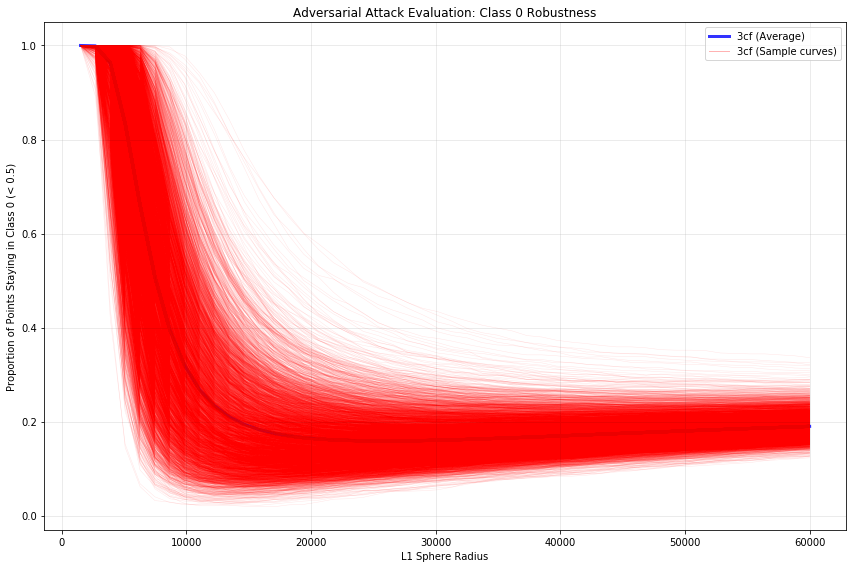

Plot saved to adversarial_attack_curves.png

Total evaluation time: 2210.93 seconds


In [25]:
import torch
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 2000)
        self.bn1 = torch.nn.BatchNorm1d(2000)
        self.dropout1 = torch.nn.Dropout(0.02)
        self.fc2 = torch.nn.Linear(2000, 200)
        self.bn2 = torch.nn.BatchNorm1d(200)
        self.dropout2 = torch.nn.Dropout(0.02)
        self.fc3 = torch.nn.Linear(200, 20)
        self.bn3 = torch.nn.BatchNorm1d(20)
        self.dropout3 = torch.nn.Dropout(0.02)
        self.fc4 = torch.nn.Linear(20, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.leaky_relu = torch.nn.LeakyReLU(0.01)
        
    def forward(self, x):
        # Handle batch norm for single samples if needed
        if x.dim() == 2 and x.size(0) == 1:
            # For a single sample, clone it to make a batch of 2
            x_batch = torch.cat([x, x], dim=0)
            x_batch = self.leaky_relu(self.bn1(self.fc1(x_batch)))
            x_batch = self.dropout1(x_batch)
            x_batch = self.leaky_relu(self.bn2(self.fc2(x_batch)))
            x_batch = self.dropout2(x_batch)
            x_batch = self.leaky_relu(self.bn3(self.fc3(x_batch)))
            x_batch = self.dropout3(x_batch)
            x_batch = self.sigmoid(self.fc4(x_batch))
            return x_batch[0:1]  # Return only the first sample
        else:
            # Normal batch processing
            x = self.leaky_relu(self.bn1(self.fc1(x)))
            x = self.dropout1(x)
            x = self.leaky_relu(self.bn2(self.fc2(x)))
            x = self.dropout2(x)
            x = self.leaky_relu(self.bn3(self.fc3(x)))
            x = self.dropout3(x)
            x = self.sigmoid(self.fc4(x))
            return x

def load_model(model_path, input_size, device):
    """Load the pretrained MLP model"""
    model = MLP(input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def sample_l1_sphere(n_points, dimensions, device):
    """
    Sample points evenly on the L1 sphere surface using coordinate-based method
    """
    # Use Dirichlet distribution for even sampling on L1 sphere
    # Sample from exponential distribution (equivalent to Dirichlet(1,1,...,1))
    samples = torch.empty(n_points, dimensions, device=device).exponential_(1.0)
    
    # Normalize to L1 norm = 1
    l1_norms = torch.sum(torch.abs(samples), dim=1, keepdim=True)
    samples = samples / l1_norms
    
    # Randomly assign signs to each coordinate
    signs = torch.randint(0, 2, (n_points, dimensions), device=device) * 2 - 1
    samples = samples * signs.float()
    
    return samples

def random_rotation_matrix(dimensions, device):
    """
    Generate a random rotation matrix using QR decomposition
    """
    # Generate random matrix
    A = torch.randn(dimensions, dimensions, device=device)
    
    # QR decomposition (use new API if available)
    try:
        Q, R = torch.linalg.qr(A, mode='reduced')
    except AttributeError:
        # Fallback for older PyTorch versions
        Q, R = torch.qr(A)
    
    # Ensure proper rotation (det = 1)
    Q = Q * torch.sign(torch.diag(R)).unsqueeze(0)
    
    return Q

def evaluate_adversarial_attacks(
    counterfactual_path,
    min_radius=0.1,
    max_radius=10.0,
    n_spheres=20,
    n_points_per_sphere=1000,
    model_path='mlp_model.pth',
    output_path='adversarial_attacks.json',
    inference_batch_size=512,  # Batch size for model inference, not for CFs
    gpu_id=0,
    plot_sample_size=50
):
    """
    Evaluate adversarial attacks by sampling points on L1 spheres around counterfactuals
    (REVISED FOR MEMORY EFFICIENCY - processes one counterfactual at a time)
    """
    start_time = time.time()
    
    # Set device
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load counterfactual data (keep on CPU)
    print("Loading counterfactual data...")
    cf_df = pd.read_parquet(counterfactual_path)
    
    # Extract feature values (keep on CPU)
    if 'original_index' in cf_df.columns:
        cf_features_cpu = cf_df.iloc[:, 1:-1].values.astype(np.float32)
    else:
        cf_features_cpu = cf_df.iloc[:, 1:].values.astype(np.float32)
    
    n_counterfactuals, n_dimensions = cf_features_cpu.shape
    print(f"Loaded {n_counterfactuals} counterfactuals with {n_dimensions} features")
    
    # Load model
    print("Loading model...")
    model = load_model(model_path, n_dimensions, device)
    
    # Generate radius values
    radii = np.linspace(min_radius, max_radius, n_spheres)
    print(f"Evaluating {n_spheres} spheres from radius {min_radius} to {max_radius}")
    
    # Sample base points on unit L1 sphere
    print(f"Sampling {n_points_per_sphere} base points on unit L1 sphere...")
    base_points = sample_l1_sphere(n_points_per_sphere, n_dimensions, device)
    
    # Storage for results - initialize with empty lists for each radius
    attack_curves = [[] for _ in radii]
    
    # Process one counterfactual at a time to save memory
    for cf_idx in tqdm(range(n_counterfactuals), desc="Processing Counterfactuals"):
        cf_tensor = torch.tensor(cf_features_cpu[cf_idx], dtype=torch.float32, device=device)
        
        for radius_idx, radius in enumerate(radii):
            # For adversarial attacks, we can use the base points directly without rotation
            # This is more memory efficient and avoids potential GPU instability
            scaled_points = base_points * radius
            
            # Create adversarial points by adding the perturbation to the counterfactual
            # Shape: [n_points, n_dimensions]
            adversarial_points = scaled_points + cf_tensor
            
            # Process model inference in small batches to prevent OOM on large n_points_per_sphere
            all_predictions = []
            for chunk_start in range(0, len(adversarial_points), inference_batch_size):
                chunk_end = min(chunk_start + inference_batch_size, len(adversarial_points))
                chunk_points = adversarial_points[chunk_start:chunk_end]
                
                with torch.no_grad():
                    chunk_predictions = model(chunk_points)
                    all_predictions.append(chunk_predictions)
            
            predictions = torch.cat(all_predictions, dim=0)
            
            # Compute proportion of points that stay in class 0 (predictions < 0.5)
            stayed_in_class0 = (predictions < 0.5).float()
            proportion = torch.mean(stayed_in_class0).item()  # .item() moves to CPU
            
            attack_curves[radius_idx].append(proportion)

            # Clean up tensors for this radius
            del scaled_points, adversarial_points, all_predictions, predictions, stayed_in_class0
    
        # Clean up tensors for this counterfactual
        del cf_tensor

    # Prepare results
    results = {
        os.path.basename(counterfactual_path).replace('.parquet', ''): {
            'x_axis': radii.tolist(),
            'attack_curves': attack_curves
        }
    }

    # Save results to JSON
    print(f"\nSaving results to {output_path}")
    try:
        # Try to load existing results
        if os.path.exists(output_path):
            with open(output_path, 'r') as f:
                try:
                    existing_results = json.load(f)
                    print(f"Loaded existing results from {output_path}")
                    # Update with new results
                    existing_results.update(results)
                    results = existing_results
                except json.JSONDecodeError:
                    print("Could not parse existing JSON, creating new file")
        
        # Save updated results
        with open(output_path, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"Results saved to {output_path}")
        
    except Exception as e:
        print(f"Error saving results: {e}")
        backup_path = f"{output_path}.backup"
        with open(backup_path, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"Backup saved to {backup_path}")

    # Plot results
    plot_adversarial_curves(results, plot_sample_size)
    
    elapsed_time = time.time() - start_time
    print(f"\nTotal evaluation time: {elapsed_time:.2f} seconds")
    
    return results

def plot_adversarial_curves(results, plot_sample_size=50):
    """
    Plot adversarial attack curves
    """
    plt.figure(figsize=(12, 8))
    
    for method_name, data in results.items():
        x_axis = data['x_axis']
        attack_curves = data['attack_curves']
        
        # Convert to numpy array for easier manipulation
        curves_array = np.array(attack_curves)  # Shape: [n_radii, n_counterfactuals]
        
        # Compute average curve
        avg_curve = np.mean(curves_array, axis=1)
        
        # Plot average curve
        plt.plot(x_axis, avg_curve, 'b-', linewidth=3, label=f'{method_name} (Average)', alpha=0.8)
        
        # Plot sample of individual curves
        n_counterfactuals = curves_array.shape[1]
        if n_counterfactuals > plot_sample_size:
            # Randomly sample curves
            sample_indices = np.random.choice(n_counterfactuals, plot_sample_size, replace=False)
            sample_curves = curves_array[:, sample_indices]
        else:
            sample_curves = curves_array
        
        # Plot individual curves with transparency
        for i in range(sample_curves.shape[1]):
            plt.plot(x_axis, sample_curves[:, i], 'r-', alpha=0.1, linewidth=0.5)
        
        # Add one representative curve to legend
        if sample_curves.shape[1] > 0:
            plt.plot([], [], 'r-', alpha=0.3, linewidth=1, 
                    label=f'{method_name} (Sample curves)')
    
    plt.xlabel('L1 Sphere Radius')
    plt.ylabel('Proportion of Points Staying in Class 0 (< 0.5)')
    plt.title('Adversarial Attack Evaluation: Class 0 Robustness')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    # Save plot
    plot_path = 'adversarial_attack_curves.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Plot saved to {plot_path}")

# Example usage
if __name__ == "__main__":
    # Example parameters
    results = evaluate_adversarial_attacks(
        counterfactual_path='3cf.parquet',
        min_radius=1500,
        max_radius=60000,
        n_spheres=50,
        n_points_per_sphere=1000,
        model_path='mlp_model.pth',
        output_path='adversarial_attacks.json',
        inference_batch_size=512,  # Renamed batch_size to be more specific
        gpu_id=1,
        plot_sample_size=5000
    )